### Project Outline
* ## [POSTGRES DATABASE / ADD STUDENT FUNCTION](#Postgres)
-  Run docker-compose file to create Docker database container
-  Create database named "student_grades" in PgAdmin
-  Connect PgAdmin server/database to Docker container
-  Send data to postgres database using SQL alchemy
-  Use psycopg2 connection to create python function that adds new students to database

* ## [EDA](#EDA)

-  Initialize repository, set up notebook, import data
-  Create GitHub repository, link to local, 1st commit + push
-  EDA
-  Data cleaning, pre-processing, etc.

* ## [Data Preparation](#Dataprep)

-  Separate Target from features
-  Train-Test Split
-  Categorical + Numerical separation, one-hot encoding, scaling etc. 


* ## [MODELING](#Modeling)
### Strategy:  simple train-test split to evaluate overall model performance.  Redo with train-val-test with hyperparameter tuning
-  Choose and build series of models
-  Train, fit, test all models
-  Choose scoring, gridsearch and optimized model run final results
-  Repeat process with new model that does predictions without previous grade data

### ANALYSIS
-  Summarize Model Results
-  Identify Executive Insights
-  Suggest areas for improvements
-  Simplify notebook with functions, pipelines, etc.
-  Final Code Documentation

#### REPORT
-  Outline Written Report
-  Write/Proofread Written Report


In [1]:
# Standard packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

# Data Preparation
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    LabelEncoder,
    TargetEncoder,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFECV

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

# Model Evaluation
from sklearn import datasets, metrics, svm
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

<a id='Postgres'></a>
## Postgres

In [2]:
data = pd.read_csv("data.csv", sep=";")
df = data.copy(deep=True)

##### Use SQLAlchemy to send data to postgres database
#### Steps:
* Export initial data to postgres database
* Create "New Student" dictionary to add row to database, convert dictionary to DataFrame
* Export new student data to existing database table with if_exists = "append" to add  to end of frame

In [3]:
# from Functions import *     # File containing functions to streamline code

# # Call data_to_postgres function with df (dataframe to export)
# # and 'student_grades' (name of postgres database table)

# data_to_postgres(df,'student_grades')

In [4]:
# # Import dictionary with new student information
# from New_Student_Info import *  
# # Call add_new function, passing new_student dictionary and 'student_grades' table name
# add_new(new_student, "student_grades")

<a id='EDA'></a>

## EDA

In [5]:
print(df.info())
print("MISSING VALUES: ", df.isnull().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      316 non-null    object
 1   sex         316 non-null    object
 2   age         316 non-null    int64 
 3   address     316 non-null    object
 4   famsize     316 non-null    object
 5   Pstatus     316 non-null    object
 6   Medu        316 non-null    int64 
 7   Fedu        316 non-null    int64 
 8   Mjob        316 non-null    object
 9   Fjob        316 non-null    object
 10  reason      316 non-null    object
 11  guardian    316 non-null    object
 12  traveltime  316 non-null    int64 
 13  studytime   316 non-null    int64 
 14  failures    316 non-null    int64 
 15  schoolsup   316 non-null    object
 16  famsup      316 non-null    object
 17  paid        316 non-null    object
 18  activities  316 non-null    object
 19  nursery     316 non-null    object
 20  higher    

In [6]:
print(df.describe().T)
print(75*"-")
display(df.head())

            count       mean       std   min   25%   50%   75%   max
age         316.0  16.693038  1.310791  15.0  16.0  17.0  18.0  22.0
Medu        316.0   2.768987  1.104301   0.0   2.0   3.0   4.0   4.0
Fedu        316.0   2.525316  1.070228   0.0   2.0   3.0   3.0   4.0
traveltime  316.0   1.436709  0.703132   1.0   1.0   1.0   2.0   4.0
studytime   316.0   2.088608  0.849872   1.0   2.0   2.0   2.0   4.0
failures    316.0   0.306962  0.724239   0.0   0.0   0.0   0.0   3.0
famrel      316.0   3.924051  0.908823   1.0   4.0   4.0   5.0   5.0
freetime    316.0   3.240506  0.968916   1.0   3.0   3.0   4.0   5.0
goout       316.0   3.151899  1.099363   1.0   2.0   3.0   4.0   5.0
Dalc        316.0   1.474684  0.899378   1.0   1.0   1.0   2.0   5.0
Walc        316.0   2.297468  1.311776   1.0   1.0   2.0   3.0   5.0
health      316.0   3.503165  1.404072   1.0   3.0   4.0   5.0   5.0
absences    316.0   5.693038  7.580096   0.0   0.0   4.0   8.0  56.0
G1          316.0  10.924051  3.19

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,16,U,LE3,T,4,3,teacher,services,...,5,4,3,1,2,1,2,16,15,15
1,GP,M,18,U,LE3,T,1,1,other,other,...,2,3,5,2,5,4,0,6,5,0
2,GP,M,17,R,LE3,A,4,4,teacher,other,...,3,3,3,2,3,4,2,10,11,12
3,GP,F,15,U,LE3,T,3,2,services,other,...,4,4,4,1,1,5,10,7,6,6
4,GP,M,16,U,GT3,T,2,3,other,other,...,5,3,3,1,1,3,0,13,14,14


In [7]:
# Separate categorical and numerical variables for investigation
numerical = [col for col in df.columns if df[col].dtype == "int64"]
categorical = [col for col in df.columns if df[col].dtype != "int64"]
print("Numerical features: ", len(numerical))
print("Categorical features: ", len(categorical))
display("Numerical features: ", df[numerical].head(2))
display("Categorical features: ", df[categorical].head(2))

Numerical features:  16
Categorical features:  17


'Numerical features: '

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,16,4,3,3,2,0,5,4,3,1,2,1,2,16,15,15
1,18,1,1,1,1,3,2,3,5,2,5,4,0,6,5,0


'Categorical features: '

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,GP,F,U,LE3,T,teacher,services,course,mother,no,yes,no,yes,yes,yes,yes,no
1,GP,M,U,LE3,T,other,other,course,mother,no,no,no,no,yes,no,yes,yes


In [8]:
df[categorical].nunique()

school        2
sex           2
address       2
famsize       2
Pstatus       2
Mjob          5
Fjob          5
reason        4
guardian      3
schoolsup     2
famsup        2
paid          2
activities    2
nursery       2
higher        2
internet      2
romantic      2
dtype: int64

In [9]:
#Split categorical features into binary and nominal for encoding flexibility
binary = [col for col in df.columns if df[col].nunique() ==2]
nominal = [col for col in df.columns if (df[col].dtype == 'object' and df[col].nunique() >2)]
#check length of 3 feature types matches total
print(len(numerical)+len(binary)+len(nominal))

33


In [10]:
# Investigate nominal categories Mjob + Fjob
display(df["Mjob"].value_counts())
display(df["Fjob"].value_counts())

Mjob
other       115
services     77
teacher      50
at_home      46
health       28
Name: count, dtype: int64

Fjob
other       175
services     86
teacher      24
at_home      16
health       15
Name: count, dtype: int64

In [11]:
# Investigate nominal categories reason + guardian
display(df["reason"].value_counts())
display(df["guardian"].value_counts())

reason
course        112
home           88
reputation     85
other          31
Name: count, dtype: int64

guardian
mother    221
father     67
other      28
Name: count, dtype: int64

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'Medu'}>,
        <Axes: title={'center': 'Fedu'}>,
        <Axes: title={'center': 'traveltime'}>],
       [<Axes: title={'center': 'studytime'}>,
        <Axes: title={'center': 'failures'}>,
        <Axes: title={'center': 'famrel'}>,
        <Axes: title={'center': 'freetime'}>],
       [<Axes: title={'center': 'goout'}>,
        <Axes: title={'center': 'Dalc'}>,
        <Axes: title={'center': 'Walc'}>,
        <Axes: title={'center': 'health'}>],
       [<Axes: title={'center': 'absences'}>,
        <Axes: title={'center': 'G1'}>, <Axes: title={'center': 'G2'}>,
        <Axes: title={'center': 'G3'}>]], dtype=object)

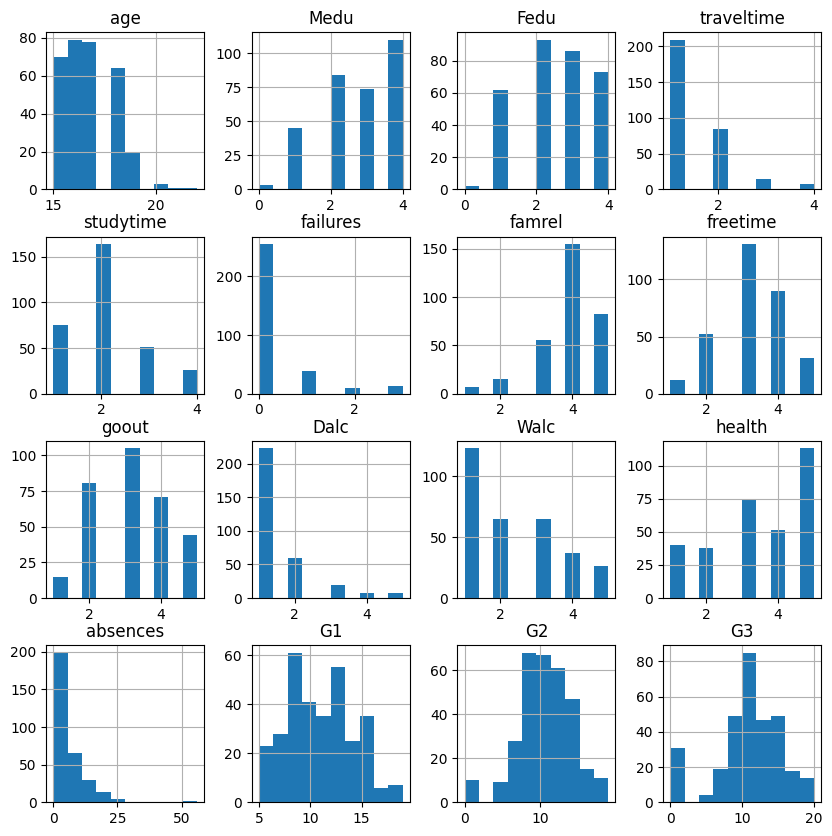

In [12]:
# Look at distribution of numerical data
df.hist(figsize=(10,10))

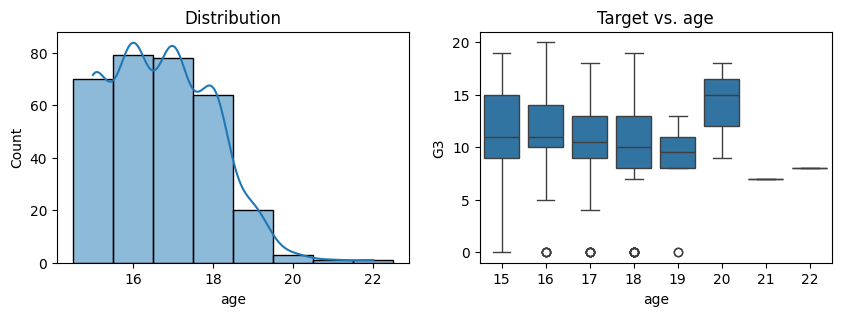

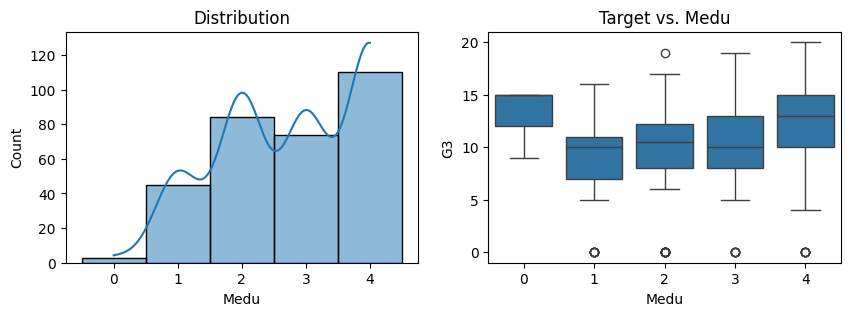

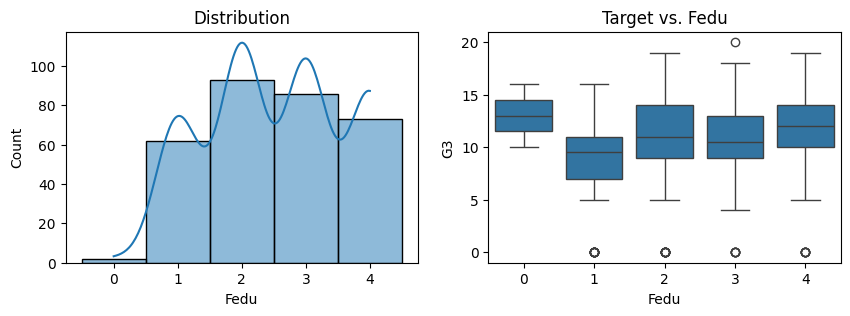

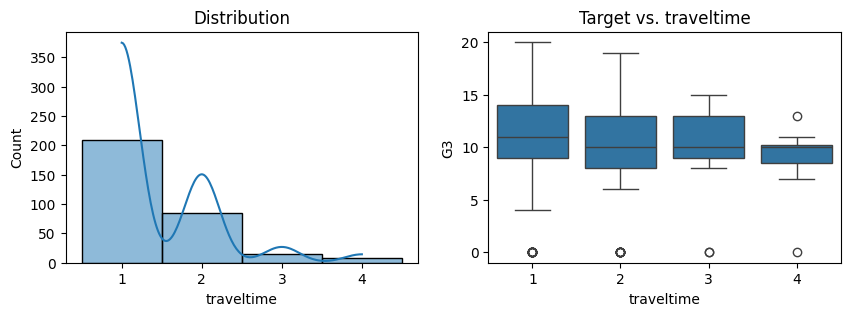

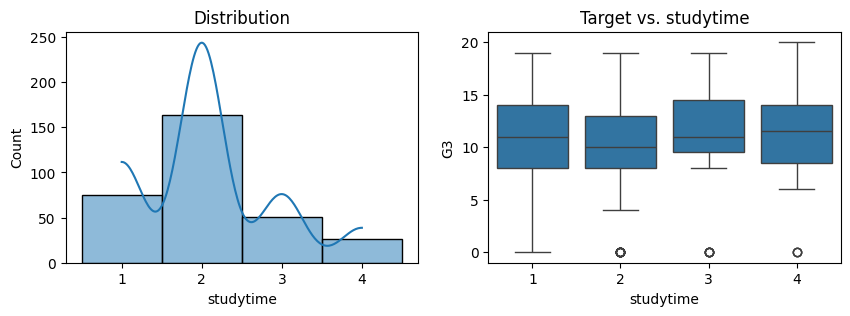

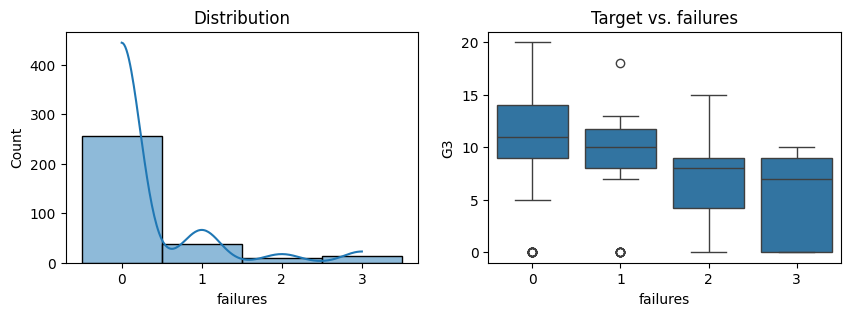

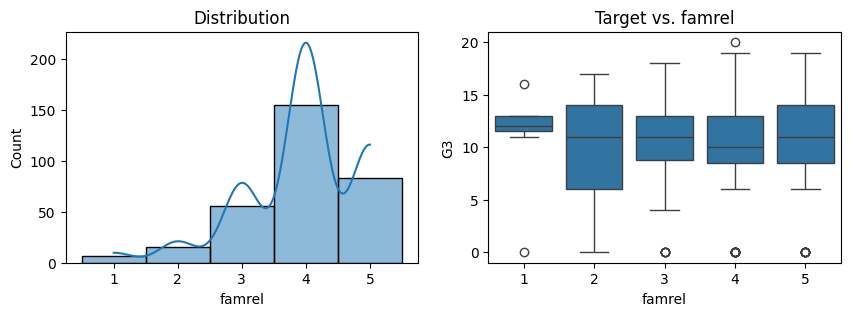

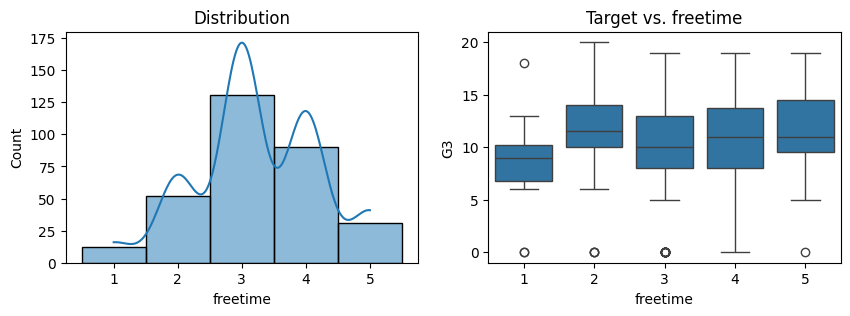

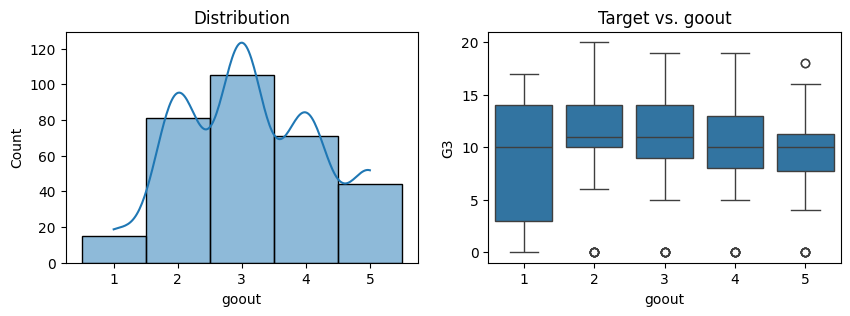

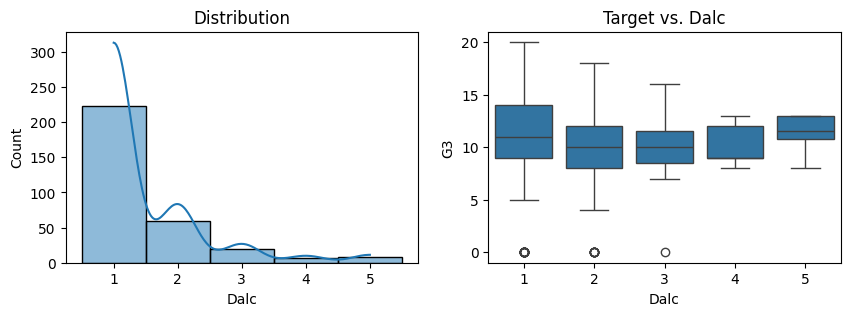

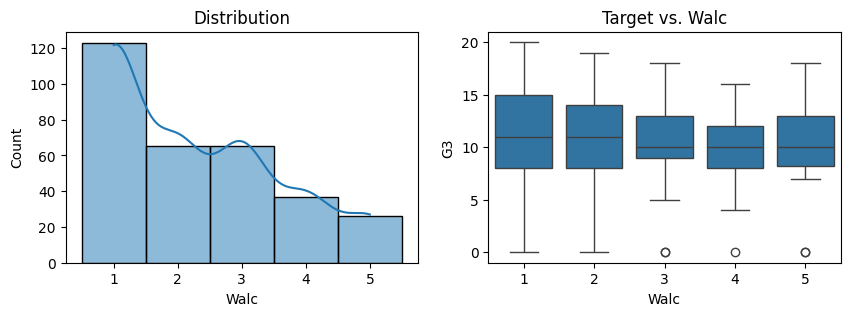

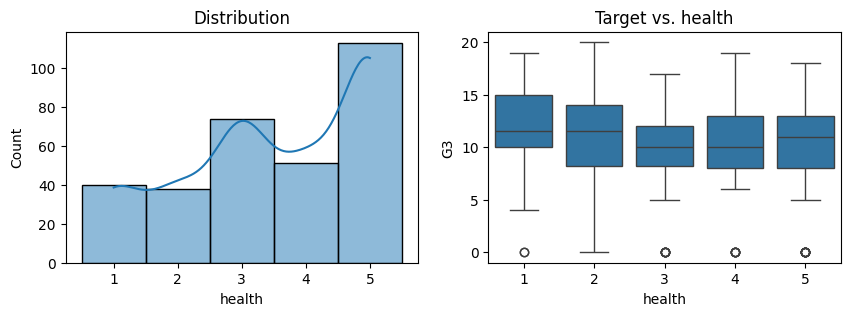

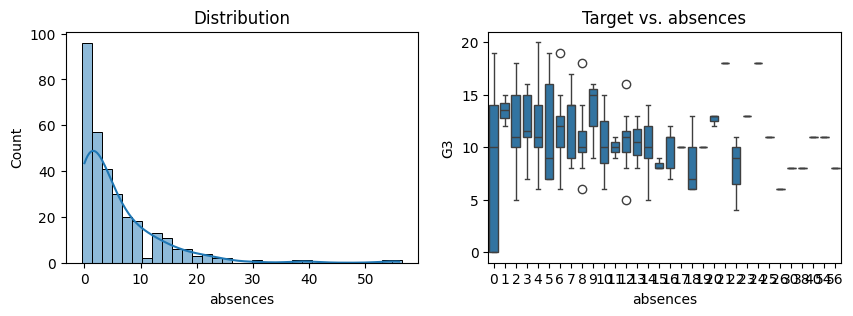

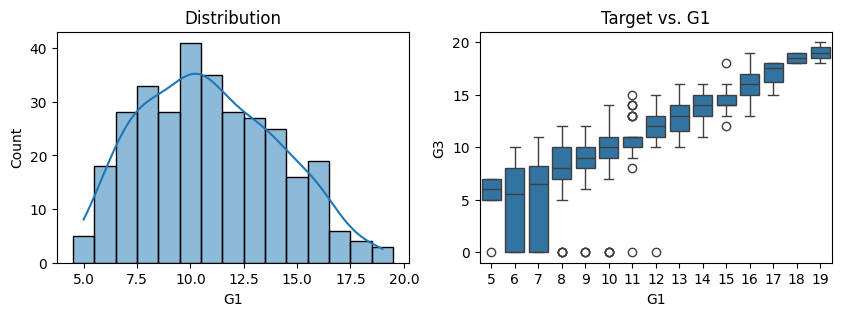

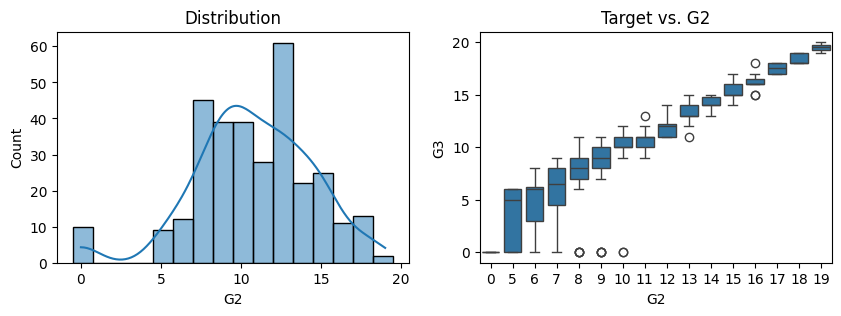

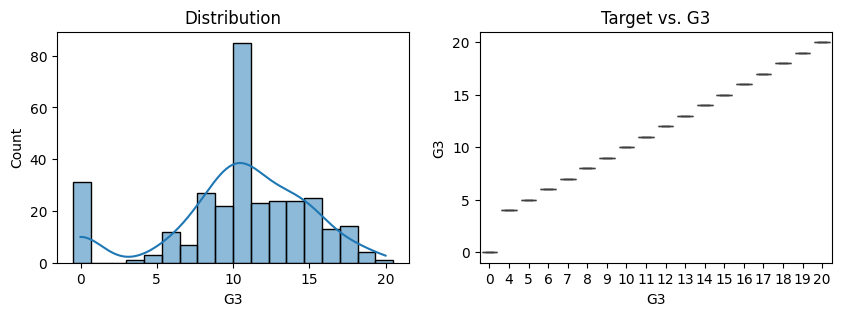

In [13]:
# Now again in more detail
for i in df[numerical].columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    bin_edges = np.linspace(df[i].min() - 0.5, df[i].max() + 0.5, df[i].nunique() + 1)
    ax1.title.set_text("Distribution")
    ax2.title.set_text(f"Target vs. {i}")
    sns.histplot(data=df, x=i, bins=bin_edges, kde=True, ax=ax1)
    sns.boxplot(data=df, x=i, y=df["G3"], ax=ax2)
    fig.tight_layout
    plt.show()

## Initial Feature Selection

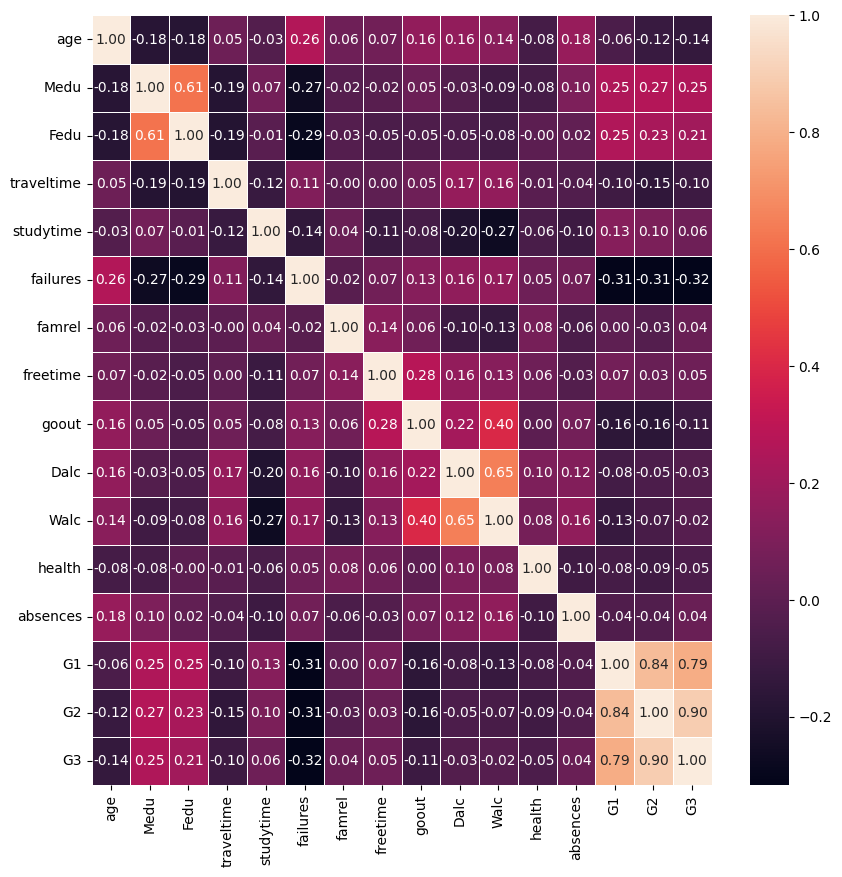

In [14]:
#check for correlation amongst numerical features
plt.figure(figsize=(10, 10))  # Adjust the figure size if needed
sns.heatmap(df[numerical].corr(), annot=True, fmt=".2f",linewidths=0.5)
plt.show()

## Create New Feature Sets, Strong Correlation and Weak Correlation

In [15]:
# Create 2 New Numerical Datasets: Weak correlation only and Strong correlation only
df_weakcorr = df.copy(deep=True)
df_weakcorr = df_weakcorr.drop(columns=["G1", "G2","failures","Dalc","Walc","goout","Fedu","Medu"])
df_strongcorr = df.copy(deep=True)
df_strongcorr = df_strongcorr[["G1", "G2","G3","failures","Dalc","Walc","goout","Fedu","Medu"]]

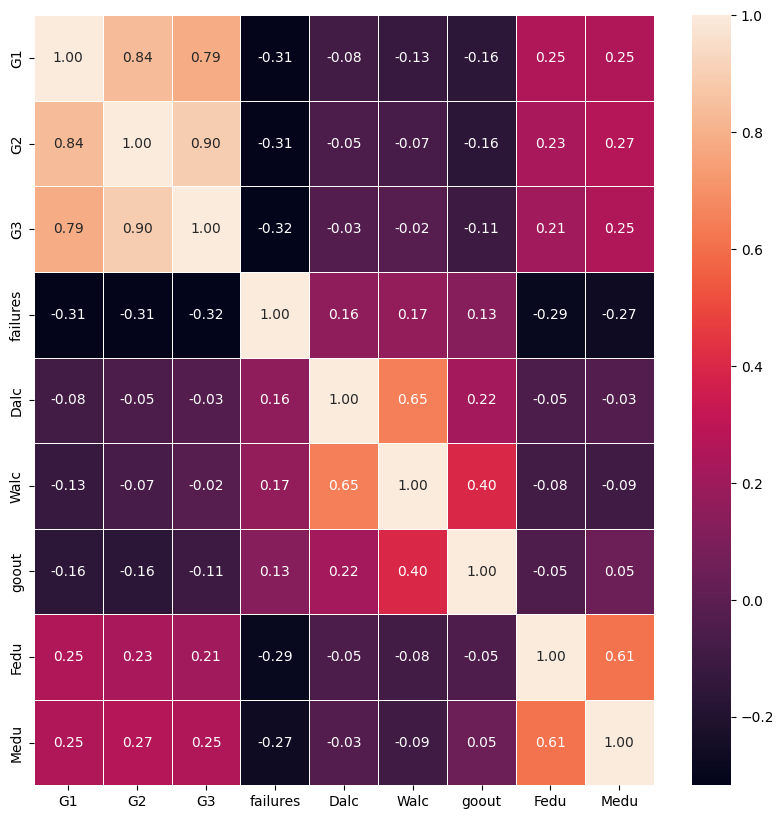

In [16]:
# Check correlation for Strong set
strongcorr_num = [col for col in df_strongcorr.columns if df_strongcorr[col].dtype != 'object']

plt.figure(figsize=(10, 10))  # Adjust the figure size if needed
sns.heatmap(df_strongcorr[strongcorr_num].corr(), annot=True, fmt=".2f", linewidths=0.5)
plt.show()

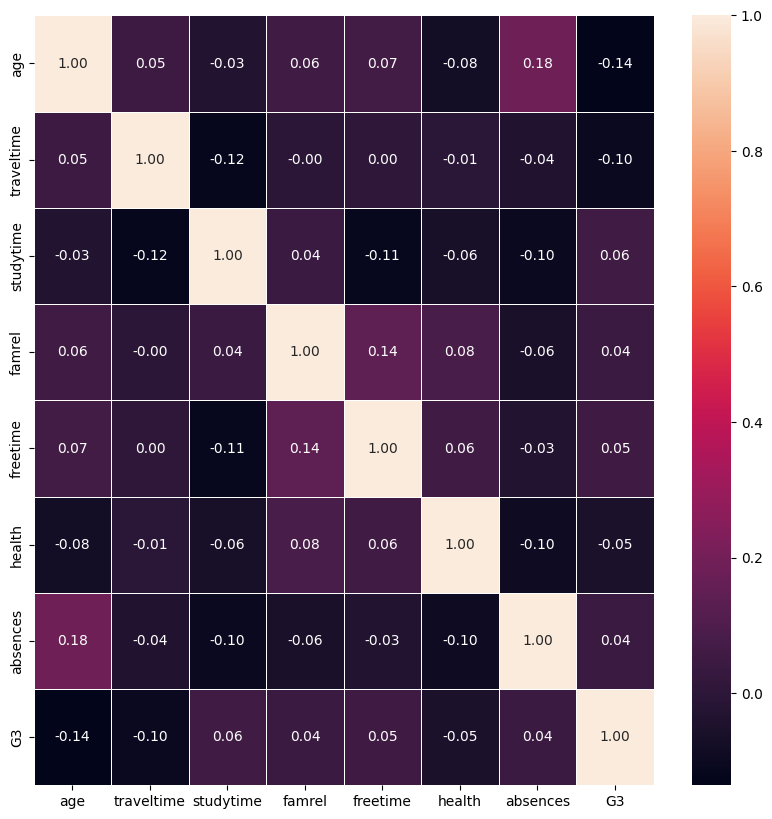

In [17]:
# Check correlation for weak set
weakcorr_num = [col for col in df_weakcorr.columns if df_weakcorr[col].dtype != 'object']

plt.figure(figsize=(10, 10))  # Adjust the figure size if needed
sns.heatmap(df_weakcorr[weakcorr_num].corr(), annot=True, fmt=".2f", linewidths=0.5)
plt.show()

## Let's try some feature engineering

#### I'll try combine some features with stronger correlation and replacing original features in df with those new features.

In [ ]:
# Try adding some new features
df_combined = df.copy(deep=True)
df_combined['Education'] = df_combined["Medu"] + df_combined["Fedu"]
df_combined['Alcohol'] = df_combined["Dalc"] + df_combined["Walc"]
df_combined['Party'] = df_combined["Walc"] + df_combined["goout"]
df_combined.drop(columns=['Medu','Fedu','Dalc','Walc','goout'],inplace=True)
df_combined.to_csv(cwd + "/df_combined.csv")

In [18]:
# Create copy of df for use in bonus model
df_bonus = df.copy(deep=True)
df_bonus = df.drop(columns=["G1", "G2"])

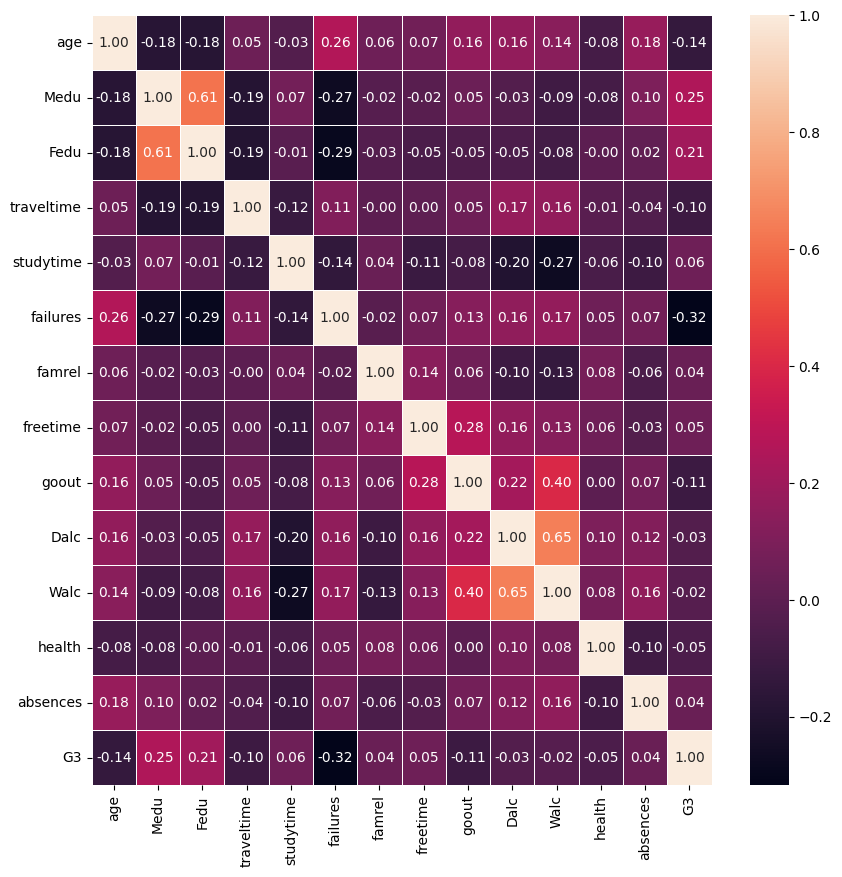

In [19]:
# Check correlation of bonus df
bonus_numerical = [col for col in numerical if col not in ("G1", "G2")]

plt.figure(figsize=(10, 10))  # Adjust the figure size if needed
sns.heatmap(df_bonus[bonus_numerical].corr(), annot=True, fmt=".2f", linewidths=0.5)
plt.show()

In [20]:
from sklearn.feature_selection import mutual_info_regression

X = df.copy()
y = X.pop("G3")

for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

discrete_features = X.dtypes == int

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[:10]

G2            1.350377
G1            0.759318
absences      0.144767
failures      0.136855
Walc          0.107462
traveltime    0.065927
paid          0.052810
Dalc          0.051918
health        0.048744
Fjob          0.042113
Name: MI Scores, dtype: float64

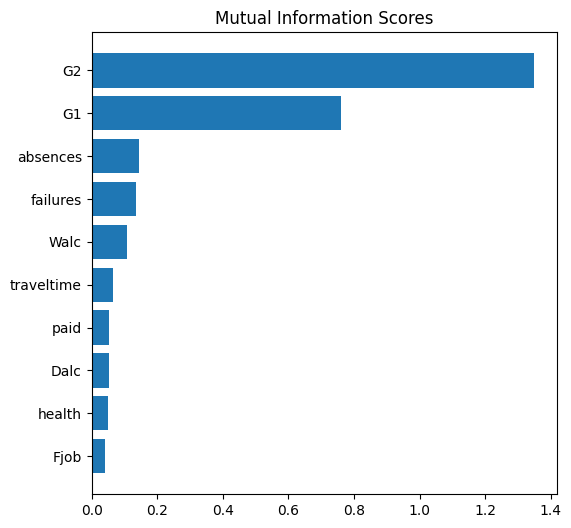

In [21]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(6, 6))
plot_mi_scores(mi_scores[:10])

In [22]:
mi_featureslist =list(mi_scores[mi_scores > 0.009].keys())
df_mi_10 = df[mi_featureslist]
df_mi_10.head()

,G2,G1,absences,failures,Walc,traveltime,paid,Dalc,health,Fjob,higher,schoolsup,nursery,age,guardian,romantic,Mjob,Medu,sex,freetime
0,15,16,2,0,2,3,no,1,1,services,yes,no,yes,16,mother,no,teacher,4,F,4
1,5,6,0,3,5,1,no,2,4,other,no,no,yes,18,mother,yes,other,1,M,3
2,11,10,2,0,3,2,yes,2,4,other,yes,no,yes,17,mother,no,teacher,4,M,3
3,6,7,10,0,1,1,yes,1,5,other,yes,no,yes,15,mother,no,services,3,F,4
4,14,13,0,0,1,2,no,1,3,other,yes,no,yes,16,father,no,other,2,M,3


## Modeling <a class="anchor" id="Modeling"></a>

#### First run all regression models on numerical features only with no hyperparamater tuning to get basic performance

In [103]:
# Model with only unprocessed numerical features, no categorical
mse = mean_squared_error
# rmse = mse**0.5
mae = mean_absolute_error
R_2 = r2_score
mape = mean_absolute_percentage_error

# Assuming X is your feature matrix with both numerical and categorical features
# Separate Target
X = df.drop("G3", axis=1)
nums = [col for col in X.columns if X[col].dtype == "int64"]
X = X[nums]
y = df["G3"]

# # # Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


# Linear Regression
random_state=42
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
lrtrainpreds = lr.predict(X_train)
lrtestpreds = lr.predict(X_test)

# Support Vector Regression
svr = SVR()
svr.fit(X_train, y_train)
svrtrainpreds = svr.predict(X_train)
svrtestpreds = svr.predict(X_test)

# Linear Support Vector Regression
lsvr = LinearSVR(random_state=42)
lsvr.fit(X_train, y_train)
lsvrtrainpreds = lsvr.predict(X_train)
lsvrtestpreds = lsvr.predict(X_test)

# Random Forest Regression
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)
rfrtrainpreds = rfr.predict(X_train)
rfrtestpreds = rfr.predict(X_test)

# Gradient Boosted Regression
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train,y_train)
gbrtrainpreds = gbr.predict(X_train)
gbrtestpreds = gbr.predict(X_test)

TRAINING PERFORMANCE


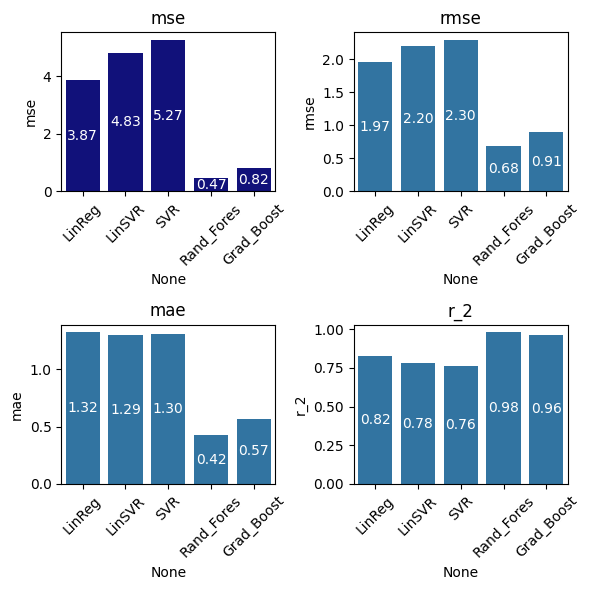

In [105]:
#Training performance
# Visually compare model scores for each of four metrics
# Create list of models
model_list = [lr,lsvr,svr,rfr,gbr]
# Initalize list of models scores
scores = []
# Store model scores in list of lists
for i in model_list:
    ipreds = i.predict(X_train)
    mse = mean_squared_error(y_train, ipreds)
    rmse = (mse**0.5)
    mae = mean_absolute_error(y_train, ipreds)
    r_2 = r2_score(y_train,ipreds)
    scores.append([mse,rmse,mae,r_2])
# Make dataframe of scores by model
df_scores = pd.DataFrame(scores, index=["LinReg","LinSVR","SVR","Rand_Fores","Grad_Boost"], columns=["mse","rmse","mae","r_2"])
# View
print("TRAINING PERFORMANCE")
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
# Set titles for each subplot
axs[0, 0].set_title("mse")
axs[0, 1].set_title("rmse")
axs[1, 0].set_title("mae")
axs[1, 1].set_title("r_2")
# Plot barplots on each subplot
sns.barplot(data=df_scores, x=df_scores.index, y="mse", ax=axs[0, 0], color='darkblue')
sns.barplot(data=df_scores, x=df_scores.index, y="rmse", ax=axs[0, 1])
sns.barplot(data=df_scores, x=df_scores.index, y="mae", ax=axs[1, 0])
sns.barplot(data=df_scores, x=df_scores.index, y="r_2", ax=axs[1, 1])
# bar_list = ['red','blue','orange','green']
# axs[0,0].bar(df_scores.index, df_scores["mse"],color='darkblue')
# Rotate x-axis labels
axs.flat[0].tick_params(axis='x', labelrotation=45)
axs.flat[1].tick_params(axis='x', labelrotation=45)
axs.flat[2].tick_params(axis='x', labelrotation=45)
axs.flat[3].tick_params(axis='x', labelrotation=45)
#Loop over subplots to add text to bars
for i in range(2):
    for j in range(2):
        for p in axs[i, j].patches:
            axs[i, j].text(p.get_x() + p.get_width() / 2., p.get_height() / 2., f'{p.get_height():.2f}',
                           ha='center', va='center',color='white')
fig.tight_layout()
# Show the plot
plt.show()

TEST PERFORMANCE


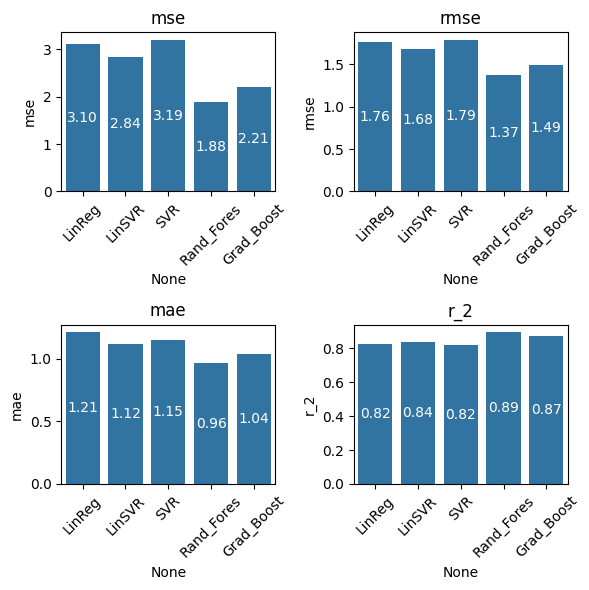

In [108]:
# Test Performance
# Create list of models
model_list = [lr,lsvr,svr,rfr,gbr]
# Initalize list of models scores
scores = []
# Store model scores in list of lists
for i in model_list:
    ipreds = i.predict(X_test)
    mse = mean_squared_error(y_test, ipreds)
    rmse = (mse**0.5)
    mae = mean_absolute_error(y_test, ipreds)
    r_2 = r2_score(y_test,ipreds)
    scores.append([mse,rmse,mae,r_2])
# Make dataframe of scores by model
df_scores = pd.DataFrame(scores, index=["LinReg","LinSVR","SVR","Rand_Fores","Grad_Boost"], columns=["mse","rmse","mae","r_2"])
print('TEST PERFORMANCE')
# View
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
# Set titles for each subplot
axs[0, 0].set_title("mse")
axs[0, 1].set_title("rmse")
axs[1, 0].set_title("mae")
axs[1, 1].set_title("r_2")
# Plot barplots on each subplot
sns.barplot(data=df_scores, x=df_scores.index, y="mse", ax=axs[0, 0])
sns.barplot(data=df_scores, x=df_scores.index, y="rmse", ax=axs[0, 1])
sns.barplot(data=df_scores, x=df_scores.index, y="mae", ax=axs[1, 0])
sns.barplot(data=df_scores, x=df_scores.index, y="r_2", ax=axs[1, 1])
# bar_list = ['red','blue','orange','green']
# axs[0,0].bar(df_scores.index, df_scores["mse"],color='darkblue')
# Rotate x-axis labels
axs.flat[0].tick_params(axis='x', labelrotation=45)
axs.flat[1].tick_params(axis='x', labelrotation=45)
axs.flat[2].tick_params(axis='x', labelrotation=45)
axs.flat[3].tick_params(axis='x', labelrotation=45)
#Loop over subplots to add text to bars
for i in range(2):
    for j in range(2):
        for p in axs[i, j].patches:
            axs[i, j].text(p.get_x() + p.get_width() / 2., p.get_height() / 2., f'{p.get_height():.2f}',
                           ha='center', va='center',color='white')
fig.tight_layout()
# Show the plot
plt.show()

#### ALL models show signigicant overfitting, with Random Forest and Gradient Boosted Regressor performing best overall.  Let's look at train and test scores together.

Train in blue, test in yellow


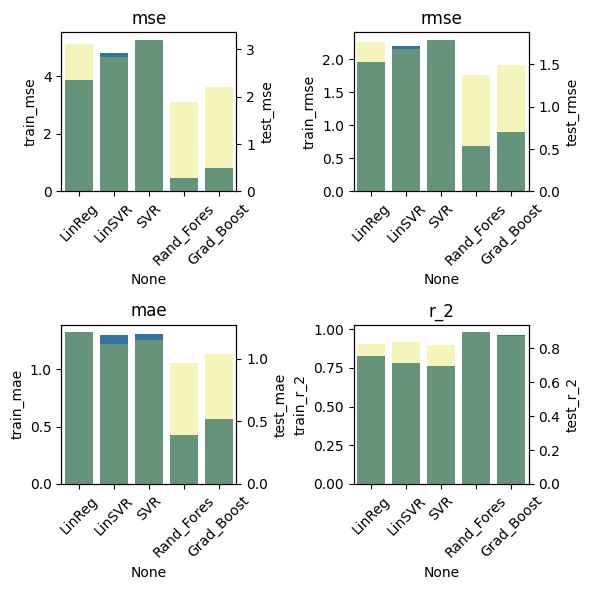

In [111]:
# Visually compare model scores for each of four metrics
# Create list of models
model_list = [lr,lsvr,svr,rfr,gbr]
# Initalize list of models scores
scores = []
# Store model scores in list of lists
for i in model_list:
    trainpreds = i.predict(X_train)
    testpreds = i.predict(X_test)
    train_mse = mean_squared_error(y_train, trainpreds)
    test_mse = mean_squared_error(y_test, testpreds)
    train_rmse = (train_mse**0.5)
    test_rmse = (test_mse**0.5)
    train_mae = mean_absolute_error(y_train, trainpreds)
    test_mae = mean_absolute_error(y_test, testpreds)
    train_r_2 = r2_score(y_train,trainpreds)
    test_r_2 = r2_score(y_test,testpreds)
    scores.append([train_mse,test_mse,train_rmse,test_rmse,train_mae,test_mae,train_r_2,test_r_2])
# Make dataframe of scores by model
df_scores = pd.DataFrame(scores, index=["LinReg","LinSVR","SVR","Rand_Fores","Grad_Boost"], 
                         columns=["train_mse","test_mse","train_rmse","test_rmse",
                                  "train_mae","test_mae","train_r_2","test_r_2"])
print("Train in blue, test in yellow")
# View
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
# Set titles for each subplot
axs[0, 0].set_title("mse")
axs[0, 1].set_title("rmse")
axs[1, 0].set_title("mae")
axs[1, 1].set_title("r_2")
# Plot barplots on each subplot
sns.barplot(data=df_scores, x=df_scores.index, y="train_mse", ax=axs[0, 0])#,label="Train"
sns.barplot(data=df_scores, x=df_scores.index, y="train_rmse", ax=axs[0, 1])
sns.barplot(data=df_scores, x=df_scores.index, y="train_mae", ax=axs[1, 0])
sns.barplot(data=df_scores, x=df_scores.index, y="train_r_2", ax=axs[1, 1])
# Share axis for test scores
axs2 = [ax.twinx() for ax in axs.flat]
# Plot second set of bars on each subplot
sns.barplot(data=df_scores, x=df_scores.index, y="test_mse", ax=axs2[0], color='yellow', alpha=0.3)
sns.barplot(data=df_scores, x=df_scores.index, y="test_rmse", ax=axs2[1], color='yellow', alpha=0.3)
sns.barplot(data=df_scores, x=df_scores.index, y="test_mae", ax=axs2[2], color='yellow', alpha=0.3)
sns.barplot(data=df_scores, x=df_scores.index, y="test_r_2", ax=axs2[3], color='yellow', alpha=0.3)
# Rotate x-axis labels
axs.flat[0].tick_params(axis='x', labelrotation=45)
axs.flat[1].tick_params(axis='x', labelrotation=45)
axs.flat[2].tick_params(axis='x', labelrotation=45)
axs.flat[3].tick_params(axis='x', labelrotation=45)

fig.tight_layout()
# axs[0, 0].legend(loc='upper right', fontsize='small')
# Show the plot
# plt.legend()
plt.show()

#### Linear regression, Linear Support Vector Regressor, and Support Vector Regressor models generally show better agreement between train/test, but Random Forest and Gradient Boosted models show much better performance.  Let's try some data processing.  Now we will train the models on the entire data set.  Categorical variables will first be one-hot encoded, and then all variables will be standardized.

In [114]:
# Define scaling functions, adjust these parameters later
standard = StandardScaler()  # subtract mean, divide by std
minmax = MinMaxScaler()  # subtract min, divide by max - min
OHE = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # create category for each value, 1 and 0's
LE = LabelEncoder()  # assign numeric value for each unique value
TE = TargetEncoder()  # assign weighted mean of target value


# DATA PREPARATION
# Separate Target
def data_prep(data, encoder, scaler):
    X = data.drop("G3", axis=1)
    y = data["G3"]

    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Separate Categorical features for encoding
    categorical_features = [col for col in X.columns if X[col].dtype == "object"]

    # CATEGORICAL FEATURE TRANSFORMER
    # transform categorical features and leave numericals alone
    cat_encoder = ColumnTransformer([("cat", encoder, categorical_features)], remainder="passthrough")
    # fit_transform on train features...
    Xtr_cat_encoded = pd.DataFrame(cat_encoder.fit_transform(X_train),columns = [feat.split('__')[1] for feat in cat_encoder.get_feature_names_out()])
    # then then transform test features
    Xte_cat_encoded = pd.DataFrame(cat_encoder.transform(X_test),columns = [feat.split('__')[1] for feat in cat_encoder.get_feature_names_out()])
    train_cols = Xtr_cat_encoded.columns
    
    # SCALER TRANSFORMER
    scale_all = ColumnTransformer([("scale",scaler,train_cols)])
    #fit_transform on all train features...
    X_train_processed = pd.DataFrame(scale_all.fit_transform(Xtr_cat_encoded),columns = [s.split('__')[1] for s in cat_encoder.get_feature_names_out()])
    #then transform all test features
    X_test_processed = pd.DataFrame(scale_all.transform(Xte_cat_encoded),columns = [s.split('__')[1] for s in cat_encoder.get_feature_names_out()])
    return X_train_processed,X_test_processed, y_train, y_test
    
    
    
X_train, X_test, y_train, y_test = data_prep(df, OHE, standard)

In [116]:
# Data has been Encoded and Scaled, model"p" for processed data
# Model with all features, cats one hot encoded
mse = mean_squared_error
mae = mean_absolute_error
R_2 = r2_score
mape = mean_absolute_percentage_error

# Linear Regression
random_state=42
lrp = LinearRegression(fit_intercept=True)
lrp.fit(X_train, y_train)
# Support Vector Regression
svrp = SVR()
svrp.fit(X_train, y_train)
# Linear Support Vector Regression
lsvrp = LinearSVR(random_state=42)
lsvrp.fit(X_train, y_train)
# Random Forest Regression
rfrp = RandomForestRegressor(random_state=42)
rfrp.fit(X_train, y_train)
# Gradient Boosted Regression
gbrp = GradientBoostingRegressor(random_state=42)
gbrp.fit(X_train,y_train)

GradientBoostingRegressor(random_state=42)

TRAINING PERFORMANCE


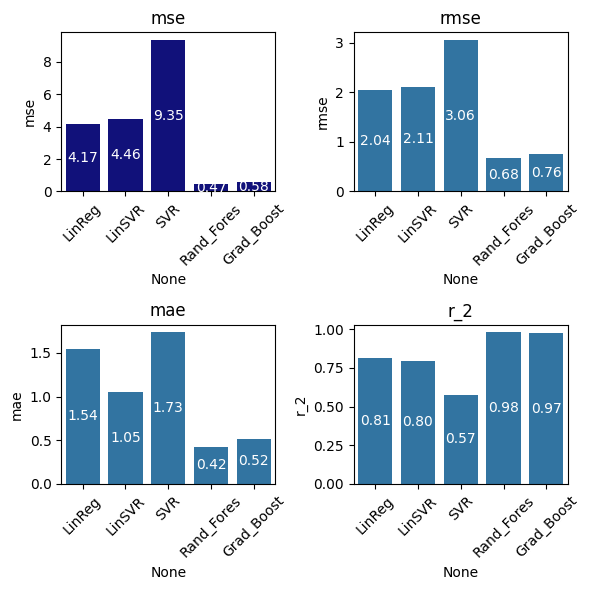

In [117]:
#Training performance
# Visually compare model scores for each of four metrics
# Create list of models
model_list = [lrp,lsvrp,svrp,rfrp,gbrp]
# Initalize list of models scores
scores = []
# Store model scores in list of lists
for i in model_list:
    ipreds = i.predict(X_train)
    mse = mean_squared_error(y_train, ipreds)
    rmse = (mse**0.5)
    mae = mean_absolute_error(y_train, ipreds)
    r_2 = r2_score(y_train,ipreds)
    scores.append([mse,rmse,mae,r_2])
# Make dataframe of scores by model
df_scores = pd.DataFrame(scores, index=["LinReg","LinSVR","SVR","Rand_Fores","Grad_Boost"], columns=["mse","rmse","mae","r_2"])
print("TRAINING PERFORMANCE")
# View
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
# Set titles for each subplot
axs[0, 0].set_title("mse")
axs[0, 1].set_title("rmse")
axs[1, 0].set_title("mae")
axs[1, 1].set_title("r_2")
# Plot barplots on each subplot
sns.barplot(data=df_scores, x=df_scores.index, y="mse", ax=axs[0, 0], color='darkblue')
sns.barplot(data=df_scores, x=df_scores.index, y="rmse", ax=axs[0, 1])
sns.barplot(data=df_scores, x=df_scores.index, y="mae", ax=axs[1, 0])
sns.barplot(data=df_scores, x=df_scores.index, y="r_2", ax=axs[1, 1])
# bar_list = ['red','blue','orange','green']
# axs[0,0].bar(df_scores.index, df_scores["mse"],color='darkblue')
# Rotate x-axis labels
axs.flat[0].tick_params(axis='x', labelrotation=45)
axs.flat[1].tick_params(axis='x', labelrotation=45)
axs.flat[2].tick_params(axis='x', labelrotation=45)
axs.flat[3].tick_params(axis='x', labelrotation=45)
#Loop over subplots to add text to bars
for i in range(2):
    for j in range(2):
        for p in axs[i, j].patches:
            axs[i, j].text(p.get_x() + p.get_width() / 2., p.get_height() / 2., f'{p.get_height():.2f}',
                           ha='center', va='center',color='white')
fig.tight_layout()
# Show the plot
plt.show()

TEST PERFORMANCE


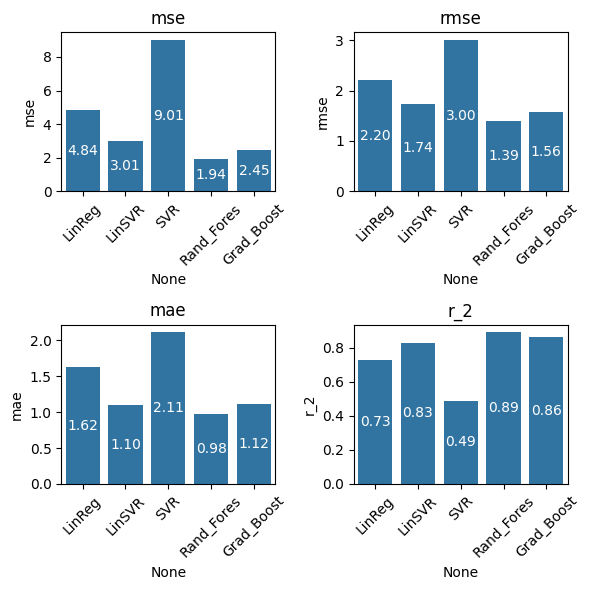

In [118]:
# Test Performance
# Create list of models
model_list = [lrp,lsvrp,svrp,rfrp,gbrp]
# Initalize list of models scores
scores = []
# Store model scores in list of lists
for i in model_list:
    ipreds = i.predict(X_test)
    mse = mean_squared_error(y_test, ipreds)
    rmse = (mse**0.5)
    mae = mean_absolute_error(y_test, ipreds)
    r_2 = r2_score(y_test,ipreds)
    scores.append([mse,rmse,mae,r_2])
# Make dataframe of scores by model
df_scores = pd.DataFrame(scores, index=["LinReg","LinSVR","SVR","Rand_Fores","Grad_Boost"], columns=["mse","rmse","mae","r_2"])
print("TEST PERFORMANCE")
# View
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
# Set titles for each subplot
axs[0, 0].set_title("mse")
axs[0, 1].set_title("rmse")
axs[1, 0].set_title("mae")
axs[1, 1].set_title("r_2")
# Plot barplots on each subplot
sns.barplot(data=df_scores, x=df_scores.index, y="mse", ax=axs[0, 0])
sns.barplot(data=df_scores, x=df_scores.index, y="rmse", ax=axs[0, 1])
sns.barplot(data=df_scores, x=df_scores.index, y="mae", ax=axs[1, 0])
sns.barplot(data=df_scores, x=df_scores.index, y="r_2", ax=axs[1, 1])
# bar_list = ['red','blue','orange','green']
# axs[0,0].bar(df_scores.index, df_scores["mse"],color='darkblue')
# Rotate x-axis labels
axs.flat[0].tick_params(axis='x', labelrotation=45)
axs.flat[1].tick_params(axis='x', labelrotation=45)
axs.flat[2].tick_params(axis='x', labelrotation=45)
axs.flat[3].tick_params(axis='x', labelrotation=45)
#Loop over subplots to add text to bars
for i in range(2):
    for j in range(2):
        for p in axs[i, j].patches:
            axs[i, j].text(p.get_x() + p.get_width() / 2., p.get_height() / 2., f'{p.get_height():.2f}',
                           ha='center', va='center',color='white')
fig.tight_layout()
# Show the plot
plt.show()

#### Performance is even better, but some overfitting still exists.  Let's see training and test together again.

Train in Blue, Test in Yellow


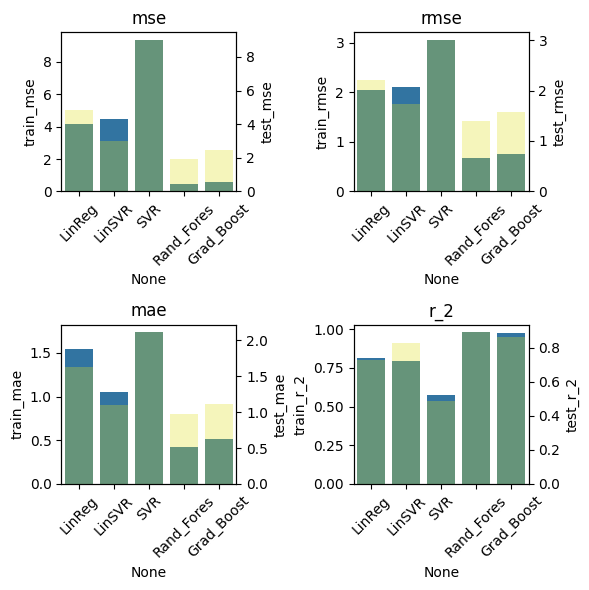

In [120]:
# Visually compare model scores for each of four metrics
# Create list of models
model_list = [lrp,lsvrp,svrp,rfrp,gbrp]
# Initalize list of models scores
scores = []
# Store model scores in list of lists
for i in model_list:
    trainpreds = i.predict(X_train)
    testpreds = i.predict(X_test)
    train_mse = mean_squared_error(y_train, trainpreds)
    test_mse = mean_squared_error(y_test, testpreds)
    train_rmse = (train_mse**0.5)
    test_rmse = (test_mse**0.5)
    train_mae = mean_absolute_error(y_train, trainpreds)
    test_mae = mean_absolute_error(y_test, testpreds)
    train_r_2 = r2_score(y_train,trainpreds)
    test_r_2 = r2_score(y_test,testpreds)
    scores.append([train_mse,test_mse,train_rmse,test_rmse,train_mae,test_mae,train_r_2,test_r_2])
# Make dataframe of scores by model
df_scores_processed = pd.DataFrame(scores, index=["LinReg","LinSVR","SVR","Rand_Fores","Grad_Boost"], 
                         columns=["train_mse","test_mse","train_rmse","test_rmse",
                                  "train_mae","test_mae","train_r_2","test_r_2"])
print("Train in Blue, Test in Yellow")
# View
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
# plt.title("Train/Test Fit Check")

# Set titles for each subplot
axs[0, 0].set_title("mse")
axs[0, 1].set_title("rmse")
axs[1, 0].set_title("mae")
axs[1, 1].set_title("r_2")
# Plot barplots on each subplot
sns.barplot(data=df_scores_processed, x=df_scores_processed.index, y="train_mse", ax=axs[0, 0])#,label="Train"
sns.barplot(data=df_scores_processed, x=df_scores_processed.index, y="train_rmse", ax=axs[0, 1])
sns.barplot(data=df_scores_processed, x=df_scores_processed.index, y="train_mae", ax=axs[1, 0])
sns.barplot(data=df_scores_processed, x=df_scores_processed.index, y="train_r_2", ax=axs[1, 1])
# Share axis for test scores
axs2 = [ax.twinx() for ax in axs.flat]
# Plot second set of bars on each subplot
sns.barplot(data=df_scores_processed, x=df_scores_processed.index, y="test_mse", ax=axs2[0], color='yellow', alpha=0.3)
sns.barplot(data=df_scores_processed, x=df_scores_processed.index, y="test_rmse", ax=axs2[1], color='yellow', alpha=0.3)
sns.barplot(data=df_scores_processed, x=df_scores_processed.index, y="test_mae", ax=axs2[2], color='yellow', alpha=0.3)
sns.barplot(data=df_scores_processed, x=df_scores_processed.index, y="test_r_2", ax=axs2[3], color='yellow', alpha=0.3)
# Rotate x-axis labels
axs.flat[0].tick_params(axis='x', labelrotation=45)
axs.flat[1].tick_params(axis='x', labelrotation=45)
axs.flat[2].tick_params(axis='x', labelrotation=45)
axs.flat[3].tick_params(axis='x', labelrotation=45)

fig.tight_layout()
# axs[0, 0].legend(loc='upper right', fontsize='small')
# Show the plot
# plt.legend()
plt.show()

#### While still overfitting, Random Forest and Gradient Boost still perform best, with a slight performance edge in favor of random forest.  As one more check, let's run a data pipeline that will use some feature selection algorithms with a few different data sets and choose our final model. 

## DATAT PIPELINE

#### First with all data, one-encoded and standardized so the algorithms can chose the best features.

In [145]:
# Define scaling functions, adjust these parameters later
standard = StandardScaler()  # subtract mean, divide by std
minmax = MinMaxScaler()  # subtract min, divide by max - min
OHE = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # create category for each value, 1 and 0's
LE = LabelEncoder()  # assign numeric value for each unique value
TE = TargetEncoder()  # assign weighted mean of target value


# DATA PREPARATION
# Separate Target
def data_prep(data, encoder, scaler):
    X = data.drop("G3", axis=1)
    y = data["G3"]

    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Separate Categorical features for encoding
    categorical_features = [col for col in X.columns if X[col].dtype == "object"]

    # CATEGORICAL FEATURE TRANSFORMER
    # transform categorical features and leave numericals alone
    cat_encoder = ColumnTransformer([("cat", encoder, categorical_features)], remainder="passthrough")
    # fit_transform on train features...
    Xtr_cat_encoded = pd.DataFrame(cat_encoder.fit_transform(X_train),columns = [feat.split('__')[1] for feat in cat_encoder.get_feature_names_out()])
    # then then transform test features
    Xte_cat_encoded = pd.DataFrame(cat_encoder.transform(X_test),columns = [feat.split('__')[1] for feat in cat_encoder.get_feature_names_out()])
    train_cols = Xtr_cat_encoded.columns
    
    # SCALER TRANSFORMER
    scale_all = ColumnTransformer([("scale",scaler,train_cols)])
    #fit_transform on all train features...
    X_train_processed = pd.DataFrame(scale_all.fit_transform(Xtr_cat_encoded),columns = [s.split('__')[1] for s in cat_encoder.get_feature_names_out()])
    #then transform all test features
    X_test_processed = pd.DataFrame(scale_all.transform(Xte_cat_encoded),columns = [s.split('__')[1] for s in cat_encoder.get_feature_names_out()])
    return X_train_processed,X_test_processed, y_train, y_test
    
    
    
X_train, X_test, y_train, y_test = data_prep(df, OHE, standard)

## MAIN PIPELINE: 

## FEATURE SELECTION + MODEL GRIDSEARCH

##### Model_1: All features, scaled/encoded, PCA(3) + SelectKBest(10)

In [162]:

# MAIN PIPELINE FOR TRANSFORMED DATA
random_state=42
k_list = list(np.arange(1,11))
scorer = {'mse':'neg_mean_squared_error','mae':'neg_mean_absolute_error'}

# Choose different number of original features
selection = SelectKBest(score_func=f_regression)

# Use selection features to transform dataset:
X_train_features = selection.fit_transform(X_train, y_train)
X_test_features = selection.transform(X_test)
print("Train space has", X_train_features.shape[1], "features")
print("Test space has", X_test_features.shape[1], "features")


# Regressor models
linreg_grid = LinearRegression()
linsvr_grid = LinearSVR()
svr_grid = SVR()
rfr_grid = RandomForestRegressor()
gbr_grid = GradientBoostingRegressor()

# Do grid search over parameters for each regressor:

linreg_param_grid = dict(
    features__k=k_list, 
    linreg_grid__fit_intercept=[True, False],  # Whether to calculate the intercept for this model
)

linsvr_param_grid = dict(
    features__k=k_list, 
    linsvr_grid__C=[0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    linsvr_grid__max_iter=[100, 200, 500]  # Maximum number of iterations
)

svr_param_grid = dict(
    features__k=k_list, 
    svr_grid__C=[0.0001, 0.001, 0.01, 0.1, 1, 10],
    svr_grid__kernel=['linear', 'rbf'],  
    svr_grid__gamma=['scale', 'auto'], 
)

rf_param_grid = dict(
    features__k=k_list, 
    rfr_grid__n_estimators=[50, 100, 200],
    rfr_grid__max_depth=[None, 10, 20],
)

gb_param_grid = dict(
    features__k=k_list, 
    gbr_grid__n_estimators=[50, 100, 200],
    gbr_grid__learning_rate=[0.01, 0.1, 0.2],
)

# Grid search for each regressor
linregmodel_1 = GridSearchCV(Pipeline([("features", selection), ("linreg_grid", linreg_grid)]), param_grid=linreg_param_grid, refit = 'mse', scoring = scorer, verbose=1)
linsvrmodel_1 = GridSearchCV(Pipeline([("features", selection), ("linsvr_grid", linsvr_grid)]), param_grid=linsvr_param_grid, refit = 'mse', scoring = scorer, verbose=1)
svrmodel_1 = GridSearchCV(Pipeline([("features", selection), ("svr_grid", svr_grid)]), param_grid=svr_param_grid, refit = 'mse', scoring = scorer, verbose=1)
rfrmodel_1 = GridSearchCV(Pipeline([("features", selection), ("rfr_grid", rfr_grid)]), param_grid=rf_param_grid, refit = 'mse', scoring = scorer, verbose=1)
gbrmodel_1 = GridSearchCV(Pipeline([("features", selection), ("gbr_grid", gbr_grid)]), param_grid=gb_param_grid, refit = 'mse', scoring = scorer, verbose=1)

# Fit the grid searches
linregmodel_1.fit(X_train, y_train)
linsvrmodel_1.fit(X_train, y_train)
svrmodel_1.fit(X_train, y_train)
rfrmodel_1.fit(X_train, y_train)
gbrmodel_1.fit(X_train, y_train)

Train space has 10 features
Test space has 10 features
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(estimator=Pipeline(steps=[('features',
                                        SelectKBest(score_func=<function f_regression at 0x1423e5800>)),
                                       ('gbr_grid',
                                        GradientBoostingRegressor())]),
             param_grid={'features__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'gbr_grid__learning_rate': [0.01, 0.1, 0.2],
                         'gbr_grid__n_estimators': [50, 100, 200]},
             refit='mse',
             scoring={'mae': 'neg_mean_absolute_error',
                      'mse': 'neg_mean_squared_error'},
             verbose=1)

In [163]:
#Save 5 best estimators from gridsearch 1
linregmodel_1 = linregmodel_1.best_estimator_
linsvrmodel_1 = linsvrmodel_1.best_estimator_
svrmodel_1 = svrmodel_1.best_estimator_
rfrmodel_1 = rfrmodel_1.best_estimator_
gbrmodel_1 = gbrmodel_1.best_estimator_

In [174]:
print(linregmodel_1.get_params)
print(linsvrmodel_1.get_params)
print(svrmodel_1.get_params)
print(rfrmodel_1.get_params)
print(gbrmodel_1.get_params)

<bound method Pipeline.get_params of Pipeline(steps=[('features',
                 SelectKBest(k=2,
                             score_func=<function f_regression at 0x1423e5800>)),
                ('linreg_grid', LinearRegression())])>
<bound method Pipeline.get_params of Pipeline(steps=[('features',
                 SelectKBest(k=2,
                             score_func=<function f_regression at 0x1423e5800>)),
                ('linsvr_grid', LinearSVR(C=100, max_iter=100))])>
<bound method Pipeline.get_params of Pipeline(steps=[('features',
                 SelectKBest(k=2,
                             score_func=<function f_regression at 0x1423e5800>)),
                ('svr_grid', SVR(C=10, kernel='linear'))])>
<bound method Pipeline.get_params of Pipeline(steps=[('features',
                 SelectKBest(k=1,
                             score_func=<function f_regression at 0x1423e5800>)),
                ('rfr_grid', RandomForestRegressor(max_depth=20))])>
<bound method Pipelin

In [172]:
# Access the FeatureUnion kbest object from the best estimator
linreg_feature_union = linregmodel_1.named_steps['features']
# linsvr_feature_union = best_linsvr.named_steps['features']
# svr_feature_union = best_svr.named_steps['features']
# rf_feature_union = best_rf.named_steps['features']
# gb_feature_union = best_gb.named_steps['features']

# Get the selected feature indices
linreg_selected_indices = linreg_feature_union.get_support()
# linsvr_selected_indices = linsvr_feature_union.get_support()
# svr_selected_indices = svr_feature_union.get_support()
# rf_selected_indices = rf_feature_union.get_support()
# gb_selected_indices = gb_feature_union.get_support()

# Get the original feature names
linreg_feature_names = X_train.columns[linreg_selected_indices]
# linsvr_feature_names = X_train.columns[linsvr_selected_indices]
# svr_feature_names = X_train.columns[svr_selected_indices]
# rf_feature_names = X_train.columns[rf_selected_indices]
# gb_feature_names = X_train.columns[gb_selected_indices]

# Print or use the feature names as needed
print("Linear Regression:", linreg_feature_names)
# print("LinearSVR:", linsvr_feature_names)
# print("SVR:", svr_feature_names)
# print("RandomForestRegressor:", rf_feature_names)
# print("GradientBoostingRegressor:", gb_feature_names)

Linear Regression: Index(['G1', 'G2'], dtype='object')


In [164]:
# df_scores_cv1:  PCA and SelectKBest (score=f_fregression) features 
model_list = [linregmodel_1,linsvrmodel_1,svrmodel_1,rfrmodel_1,gbrmodel_1]
# Initalize list of models scores
scores = []
# Store model scores in list of lists
for i in model_list:
    trainpreds = i.predict(X_train)
    testpreds = i.predict(X_test)
    train_mse = mean_squared_error(y_train, trainpreds)
    test_mse = mean_squared_error(y_test, testpreds)
    train_rmse = (train_mse**0.5)
    test_rmse = (test_mse**0.5)
    train_mae = mean_absolute_error(y_train, trainpreds)
    test_mae = mean_absolute_error(y_test, testpreds)
    train_r_2 = r2_score(y_train,trainpreds)
    test_r_2 = r2_score(y_test,testpreds)
    scores.append([train_mse,test_mse,train_rmse,test_rmse,train_mae,test_mae,train_r_2,test_r_2])
# Make dataframe of scores by model
df_scores_cv1 = pd.DataFrame(scores, index=["LinReg1","LinSVR1","SVR1","Rand_Fores1","Grad_Boost1"], 
                         columns=["train_mse","test_mse","train_rmse","test_rmse",
                                  "train_mae","test_mae","train_r_2","test_r_2"])
df_scores_cv1

,train_mse,test_mse,train_rmse,test_rmse,train_mae,test_mae,train_r_2,test_r_2
LinReg1,4.506500,2.657004,2.122852,1.630032,1.294363,1.084593,0.795195,0.849388
LinSVR1,4.850404,2.661409,2.202363,1.631382,1.351135,1.069471,0.779566,0.849138
SVR1,4.986838,2.451039,2.233123,1.565580,1.095079,0.856758,0.773366,0.861063
Rand_Fores1,4.401881,2.750497,2.098066,1.658462,1.255625,1.047203,0.799950,0.844089
Grad_Boost1,4.400901,2.775660,2.097833,1.666031,1.258590,1.063236,0.799994,0.842662


In [146]:

# MAIN PIPELINE FOR TRANSFORMED DATA
random_state=42
k_list = list(np.arange(1,11))
scorer = {'mse':'neg_mean_squared_error','mae':'neg_mean_absolute_error'}
# PCA Selector
pca = PCA()

# Choose different number of original features
selection = SelectKBest(score_func=f_regression)

# Use SelectKBest only: comment out combined features and FeatureUnion below
# X_features = selection.fit_transform(X_train, y_train)


# Join PCA features and original features
combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset: comment out statement above
X_features = combined_features.fit_transform(X_train, y_train)
print("Combined space has", X_features.shape[1], "features")

# Regressor models
linreg_grid = LinearRegression()
linsvr_grid = LinearSVR()
svr_grid = SVR()
rfr_grid = RandomForestRegressor()
gbr_grid = GradientBoostingRegressor()

# Do grid search over parameters for each regressor:

linreg_param_grid = dict(
    features__pca__n_components=[1, 2, 3],
    features__univ_select__k=k_list, 
    linreg_grid__fit_intercept=[True, False],  # Whether to calculate the intercept for this model
)

linsvr_param_grid = dict(
    features__pca__n_components=[1, 2, 3],
    features__univ_select__k=k_list, 
    linsvr_grid__C=[0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    linsvr_grid__max_iter=[100, 200, 500]  # Maximum number of iterations
)

svr_param_grid = dict(
    features__pca__n_components=[1, 2, 3],
    features__univ_select__k=k_list, 
    svr_grid__C=[0.0001, 0.001, 0.01, 0.1, 1, 10],
    svr_grid__kernel=['linear', 'rbf'],  
    svr_grid__gamma=['scale', 'auto'], 
)

rf_param_grid = dict(
    features__pca__n_components=[1, 2, 3],
    features__univ_select__k=k_list,
    rfr_grid__n_estimators=[50, 100, 200],
    rfr_grid__max_depth=[None, 10, 20],
)

gb_param_grid = dict(
    features__pca__n_components=[1, 2, 3],
    features__univ_select__k=k_list,
    gbr_grid__n_estimators=[50, 100, 200],
    gbr_grid__learning_rate=[0.01, 0.1, 0.2],
)

# Grid search for each regressor
linregmodel_1 = GridSearchCV(Pipeline([("features", combined_features), ("linreg_grid", linreg_grid)]), param_grid=linreg_param_grid, refit = 'mse', scoring = scorer, verbose=1)
linsvrmodel_1 = GridSearchCV(Pipeline([("features", combined_features), ("linsvr_grid", linsvr_grid)]), param_grid=linsvr_param_grid, refit = 'mse', scoring = scorer, verbose=1)
svrmodel_1 = GridSearchCV(Pipeline([("features", combined_features), ("svr_grid", svr_grid)]), param_grid=svr_param_grid, refit = 'mse', scoring = scorer, verbose=1)
rfrmodel_1 = GridSearchCV(Pipeline([("features", combined_features), ("rfr_grid", rfr_grid)]), param_grid=rf_param_grid, refit = 'mse', scoring = scorer, verbose=1)
gbrmodel_1 = GridSearchCV(Pipeline([("features", combined_features), ("gbr_grid", gbr_grid)]), param_grid=gb_param_grid, refit = 'mse', scoring = scorer, verbose=1)

# Fit the grid searches
linregmodel_1.fit(X_train, y_train)
linsvrmodel_1.fit(X_train, y_train)
svrmodel_1.fit(X_train, y_train)
rfrmodel_1.fit(X_train, y_train)
gbrmodel_1.fit(X_train, y_train)

Combined space has 68 features
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


GridSearchCV(estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('pca',
                                                                        PCA()),
                                                                       ('univ_select',
                                                                        SelectKBest(score_func=<function f_regression at 0x1423e5800>))])),
                                       ('gbr_grid',
                                        GradientBoostingRegressor())]),
             param_grid={'features__pca__n_components': [1, 2, 3],
                         'features__univ_select__k': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                         'gbr_grid__learning_rate': [0.01, 0.1, 0.2],
                         'gbr_grid__n_estimators': [50, 100, 200]},
             refit='mse',
             scoring={'mae': 'neg_mean_absolute_error',
                      'mse': 'neg_mean_squared_error'},
             verbose=1)

In [147]:
#Save 5 best estimators from gridsearch 1
linregmodel_1 = linregmodel_1.best_estimator_
linsvrmodel_1 = linsvrmodel_1.best_estimator_
svrmodel_1 = svrmodel_1.best_estimator_
rfrmodel_1 = rfrmodel_1.best_estimator_
gbrmodel_1 = gbrmodel_1.best_estimator_

In [148]:
# df_scores_cv1:  PCA and SelectKBest (score=f_fregression) features 
model_list = [linregmodel_1,linsvrmodel_1,svrmodel_1,rfrmodel_1,gbrmodel_1]
# Initalize list of models scores
scores = []
# Store model scores in list of lists
for i in model_list:
    trainpreds = i.predict(X_train)
    testpreds = i.predict(X_test)
    train_mse = mean_squared_error(y_train, trainpreds)
    test_mse = mean_squared_error(y_test, testpreds)
    train_rmse = (train_mse**0.5)
    test_rmse = (test_mse**0.5)
    train_mae = mean_absolute_error(y_train, trainpreds)
    test_mae = mean_absolute_error(y_test, testpreds)
    train_r_2 = r2_score(y_train,trainpreds)
    test_r_2 = r2_score(y_test,testpreds)
    scores.append([train_mse,test_mse,train_rmse,test_rmse,train_mae,test_mae,train_r_2,test_r_2])
# Make dataframe of scores by model
df_scores_cv1 = pd.DataFrame(scores, index=["LinReg1","LinSVR1","SVR1","Rand_Fores1","Grad_Boost1"], 
                         columns=["train_mse","test_mse","train_rmse","test_rmse",
                                  "train_mae","test_mae","train_r_2","test_r_2"])
df_scores_cv1

,train_mse,test_mse,train_rmse,test_rmse,train_mae,test_mae,train_r_2,test_r_2
LinReg1,4.506169,2.655457,2.122774,1.629557,1.295873,1.084988,0.795210,0.849476
LinSVR1,4.702426,2.812226,2.168508,1.676969,1.329568,1.133627,0.786291,0.840589
SVR1,4.698081,2.847286,2.167506,1.687390,1.081925,0.992579,0.786489,0.838602
Rand_Fores1,0.738316,6.006354,0.859253,2.450786,0.534515,1.532911,0.966446,0.659531
Grad_Boost1,2.239407,5.040665,1.496465,2.245143,0.933028,1.483871,0.898227,0.714271


##### Model_2: All features, scaled/encoded, Only SelectKBest(10)

In [152]:

# MAIN PIPELINE FOR TRANSFORMED DATA
random_state=42
k_list = list(np.arange(1,11))
scorer = {'mse':'neg_mean_squared_error','mae':'neg_mean_absolute_error'}
# PCA Selector
pca = PCA()

# Choose different number of original features
selection = SelectKBest(score_func=f_regression)

# Use SelectKBest only: comment out combined features and FeatureUnion below
X_train = selection.fit_transform(X_train, y_train)
X_test = selection.transform(X_test)
# Join PCA features and original features
# selection = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset: comment out statement above
# selection = selection.fit_transform(X_train, y_train)
print("Combined space has", selection.shape[1], "features")
print(combined_features)
# Regressor models
linreg_grid = LinearRegression()
linsvr_grid = LinearSVR()
svr_grid = SVR()
rfr_grid = RandomForestRegressor()
gbr_grid = GradientBoostingRegressor()

# Do grid search over parameters for each regressor:

linreg_param_grid = dict(
    # features__pca__n_components=[1, 2, 3],
    features__univ_select__k=k_list, 
    linreg_grid__fit_intercept=[True, False],  # Whether to calculate the intercept for this model
)

linsvr_param_grid = dict(
    # features__pca__n_components=[1, 2, 3],
    features__univ_select__k=k_list, 
    linsvr_grid__C=[0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    linsvr_grid__max_iter=[100, 200, 500]  # Maximum number of iterations
)

svr_param_grid = dict(
    # features__pca__n_components=[1, 2, 3],
    features__univ_select__k=k_list, 
    svr_grid__C=[0.0001, 0.001, 0.01, 0.1, 1, 10],
    svr_grid__kernel=['linear', 'rbf'],  
    svr_grid__gamma=['scale', 'auto'], 
)

rf_param_grid = dict(
    # features__pca__n_components=[1, 2, 3],
    features__univ_select__k=k_list,
    rfr_grid__n_estimators=[50, 100, 200],
    rfr_grid__max_depth=[None, 10, 20],
)

gb_param_grid = dict(
    # features__pca__n_components=[1, 2, 3],
    features__univ_select__k=k_list,
    gbr_grid__n_estimators=[50, 100, 200],
    gbr_grid__learning_rate=[0.01, 0.1, 0.2],
)

linregmodel_2 = GridSearchCV(Pipeline([("features", selection), ("linreg_grid", linreg_grid)]), param_grid=linreg_param_grid, refit = 'mse', scoring = scorer, verbose=1)
linsvrmodel_2 = GridSearchCV(Pipeline([("features", selection), ("linsvr_grid", linsvr_grid)]), param_grid=linsvr_param_grid, refit = 'mse', scoring = scorer, verbose=1)
svrmodel_2 = GridSearchCV(Pipeline([("features", selection), ("svr_grid", svr_grid)]), param_grid=svr_param_grid, refit = 'mse', scoring = scorer, verbose=1)
rfrmodel_2 = GridSearchCV(Pipeline([("features", selection), ("rfr_grid", rfr_grid)]), param_grid=rf_param_grid, refit = 'mse', scoring = scorer, verbose=1)
gbrmodel_2 = GridSearchCV(Pipeline([("features", selection), ("gbr_grid", gbr_grid)]), param_grid=gb_param_grid, refit = 'mse', scoring = scorer, verbose=1)

# Fit the grid searches
linregmodel_2.fit(X_train, y_train)
linsvrmodel_2.fit(X_train, y_train)
svrmodel_2.fit(X_train, y_train)
rfrmodel_2.fit(X_train, y_train)
gbrmodel_2.fit(X_train, y_train)

Combined space has 10 features
FeatureUnion(transformer_list=[('pca', PCA()),
                               ('univ_select',
                                SelectKBest(score_func=<function f_regression at 0x1423e5800>))])


In [134]:
kbest_linreg = linreg_grid_search.best_estimator_
kbest_linsvr = linsvr_grid_search.best_estimator_
kbest_svr = svr_grid_search.best_estimator_
kbest_rfr = rf_grid_search.best_estimator_
kbest_gbr = gb_grid_search.best_estimator_

In [143]:
kbest_linreg

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('pca', PCA(n_components=1)),
                                                ('univ_select',
                                                 SelectKBest(k=2,
                                                             score_func=<function f_regression at 0x1423e5800>))])),
                ('linreg_grid', LinearRegression())])

In [135]:
# df_scores_cv2:  Only SelectKBest up tp 10 (score=f_fregression) features 
model_list = [kbest_linreg,kbest_linsvr,kbest_svr,kbest_rfr,kbest_gbr]
# Initalize list of models scores
scores = []
# Store model scores in list of lists
for i in model_list:
    trainpreds = i.predict(X_train)
    testpreds = i.predict(X_test)
    train_mse = mean_squared_error(y_train, trainpreds)
    test_mse = mean_squared_error(y_test, testpreds)
    train_rmse = (train_mse**0.5)
    test_rmse = (test_mse**0.5)
    train_mae = mean_absolute_error(y_train, trainpreds)
    test_mae = mean_absolute_error(y_test, testpreds)
    train_r_2 = r2_score(y_train,trainpreds)
    test_r_2 = r2_score(y_test,testpreds)
    scores.append([train_mse,test_mse,train_rmse,test_rmse,train_mae,test_mae,train_r_2,test_r_2])
# Make dataframe of scores by model
df_scores_cv2 = pd.DataFrame(scores, index=["LinReg","LinSVR","SVR","Rand_Fores","Grad_Boost"], 
                         columns=["train_mse","test_mse","train_rmse","test_rmse",
                                  "train_mae","test_mae","train_r_2","test_r_2"])
df_scores_cv2

,train_mse,test_mse,train_rmse,test_rmse,train_mae,test_mae,train_r_2,test_r_2
LinReg,4.506169,2.655457,2.122774,1.629557,1.295873,1.084988,0.795210,0.849476
LinSVR,4.707033,2.813634,2.169570,1.677389,1.330249,1.134331,0.786082,0.840510
SVR,4.698081,2.847286,2.167506,1.687390,1.081925,0.992579,0.786489,0.838602
Rand_Fores,0.799608,5.162630,0.894208,2.272142,0.540793,1.419724,0.963661,0.707357
Grad_Boost,2.239407,5.040665,1.496465,2.245143,0.933028,1.483871,0.898227,0.714271


#### Ensemble methods are performing worse on test that on training.  This makes sense but the amount of overfitting is still significant, and worse for gradient boost.  Linear models and SVR are performing better on training than on test.  This is an unexpected result and makes these models less trustworthy.  Let's keep trying.

#### I will now run the feature selection pipeline with the original, unscaled, numbers only dataset.

In [ ]:
#### 

In [138]:

# Bring back original data, numbers only, KBest (up to 10 features) only
X = df.drop("G3", axis=1)
nums = [col for col in X.columns if X[col].dtype == "int64"]
X = X[nums]
y = df["G3"]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# MAIN PIPELINE FOR TRANSFORMED DATA
random_state=42
k_list = list(np.arange(1,11))
scorer = {'mse':'neg_mean_squared_error','mae':'neg_mean_absolute_error'}
# PCA Selector
pca = PCA()

# Choose different number of original features
selection = SelectKBest(score_func=f_regression)

# Use SelectKBest only: comment out combined features and FeatureUnion below
X_features = selection.fit_transform(X_train, y_train)


# Join PCA features and original features
# combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset: comment out statement above
# X_features = combined_features.fit_transform(X_train, y_train)
print("Combined space has", X_features.shape[1], "features")

# Regressor models
linreg_grid = LinearRegression()
linsvr_grid = LinearSVR()
svr_grid = SVR()
rfr_grid = RandomForestRegressor()
gbr_grid = GradientBoostingRegressor()

# Do grid search over parameters for each regressor:

linreg_param_grid = dict(
    features__pca__n_components=[1, 2, 3],
    features__univ_select__k=k_list, 
    linreg_grid__fit_intercept=[True, False],  # Whether to calculate the intercept for this model
)

linsvr_param_grid = dict(
    features__pca__n_components=[1, 2, 3],
    features__univ_select__k=k_list, 
    linsvr_grid__C=[0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    linsvr_grid__max_iter=[100, 200, 500]  # Maximum number of iterations
)

svr_param_grid = dict(
    features__pca__n_components=[1, 2, 3],
    features__univ_select__k=k_list, 
    svr_grid__C=[0.0001, 0.001, 0.01, 0.1, 1, 10],
    svr_grid__kernel=['linear', 'rbf'],  
    svr_grid__gamma=['scale', 'auto'], 
)

rf_param_grid = dict(
    features__pca__n_components=[1, 2, 3],
    features__univ_select__k=k_list,
    rfr_grid__n_estimators=[50, 100, 200],
    rfr_grid__max_depth=[None, 10, 20],
)

gb_param_grid = dict(
    features__pca__n_components=[1, 2, 3],
    features__univ_select__k=k_list,
    gbr_grid__n_estimators=[50, 100, 200],
    gbr_grid__learning_rate=[0.01, 0.1, 0.2],
)

# Grid search for each regressor
linreg_grid_search = GridSearchCV(Pipeline([("features", combined_features), ("linreg_grid", linreg_grid)]), param_grid=linreg_param_grid, refit = 'mse', scoring = scorer, verbose=1)
linsvr_grid_search = GridSearchCV(Pipeline([("features", combined_features), ("linsvr_grid", linsvr_grid)]), param_grid=linsvr_param_grid, refit = 'mse', scoring = scorer, verbose=1)
svr_grid_search = GridSearchCV(Pipeline([("features", combined_features), ("svr_grid", svr_grid)]), param_grid=svr_param_grid, refit = 'mse', scoring = scorer, verbose=1)
rf_grid_search = GridSearchCV(Pipeline([("features", combined_features), ("rfr_grid", rfr_grid)]), param_grid=rf_param_grid, refit = 'mse', scoring = scorer, verbose=1)
gb_grid_search = GridSearchCV(Pipeline([("features", combined_features), ("gbr_grid", gbr_grid)]), param_grid=gb_param_grid, refit = 'mse', scoring = scorer, verbose=1)

# Fit the grid searches
linreg_grid_search.fit(X_train, y_train)
linsvr_grid_search.fit(X_train, y_train)
svr_grid_search.fit(X_train, y_train)
rf_grid_search.fit(X_train, y_train)
gb_grid_search.fit(X_train, y_train)

Combined space has 10 features
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


GridSearchCV(estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('pca',
                                                                        PCA()),
                                                                       ('univ_select',
                                                                        SelectKBest(score_func=<function f_regression at 0x1423e5800>))])),
                                       ('gbr_grid',
                                        GradientBoostingRegressor())]),
             param_grid={'features__pca__n_components': [1, 2, 3],
                         'features__univ_select__k': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                         'gbr_grid__learning_rate': [0.01, 0.1, 0.2],
                         'gbr_grid__n_estimators': [50, 100, 200]},
             refit='mse',
             scoring={'mae': 'neg_mean_absolute_error',
                      'mse': 'neg_mean_squared_error'},
             verbose=1)

In [139]:
kbest_num_linreg = linreg_grid_search.best_estimator_
kbest_num_linsvr = linsvr_grid_search.best_estimator_
kbest_num_svr = svr_grid_search.best_estimator_
kbest_num_rfr = rf_grid_search.best_estimator_
kbest_num_gbr = gb_grid_search.best_estimator_

In [140]:
# df_scores_cv3:  Original numerical features only
# Only SelectKBest up tp 10 (score=f_fregression) features 
model_list = [kbest_num_linreg,kbest_num_linsvr,kbest_num_svr,kbest_num_rfr,kbest_num_gbr]
# Initalize list of models scores
scores = []
# Store model scores in list of lists
for i in model_list:
    trainpreds = i.predict(X_train)
    testpreds = i.predict(X_test)
    train_mse = mean_squared_error(y_train, trainpreds)
    test_mse = mean_squared_error(y_test, testpreds)
    train_rmse = (train_mse**0.5)
    test_rmse = (test_mse**0.5)
    train_mae = mean_absolute_error(y_train, trainpreds)
    test_mae = mean_absolute_error(y_test, testpreds)
    train_r_2 = r2_score(y_train,trainpreds)
    test_r_2 = r2_score(y_test,testpreds)
    scores.append([train_mse,test_mse,train_rmse,test_rmse,train_mae,test_mae,train_r_2,test_r_2])
# Make dataframe of scores by model
df_scores_cv3 = pd.DataFrame(scores, index=["LinReg","LinSVR","SVR","Rand_Fores","Grad_Boost"], 
                         columns=["train_mse","test_mse","train_rmse","test_rmse",
                                  "train_mae","test_mae","train_r_2","test_r_2"])
df_scores_cv3

,train_mse,test_mse,train_rmse,test_rmse,train_mae,test_mae,train_r_2,test_r_2
LinReg,4.367062,2.752579,2.089752,1.659090,1.312853,1.121004,0.801532,0.843971
LinSVR,5.031721,2.483698,2.243150,1.575975,1.081784,0.853444,0.771326,0.859212
SVR,3.479128,2.034704,1.865242,1.426430,0.989222,0.921553,0.841886,0.884663
Rand_Fores,0.475377,1.713909,0.689476,1.309163,0.417300,0.905063,0.978396,0.902847
Grad_Boost,1.108310,1.897825,1.052763,1.377616,0.693791,1.004049,0.949631,0.892422


In [36]:
# print(best_linreg)
print(linreg_grid_search.best_params_)
linreg_trainpreds = best_linreg.predict(X_train)
linreg_testpreds = best_linreg.predict(X_test)
print("train mse: ",mean_squared_error(y_train,linreg_trainpreds))
print("test mse: ",mean_squared_error(y_test,linreg_testpreds))
print("train mae: ",mean_absolute_error(y_train,linreg_trainpreds))
print("test mae: ",mean_absolute_error(y_test,linreg_testpreds))
print("train R2: ",r2_score(y_train,linreg_trainpreds))
print("test R2: ",r2_score(y_test,linreg_testpreds))

{'features__pca__n_components': 1, 'features__univ_select__k': 2, 'linreg_grid__fit_intercept': True}
train mse:  4.506169254938451
test mse:  2.6554569305657196
train mae:  1.2958726366197388
test mae:  1.0849880836225922
train R2:  0.7952102528928375
test R2:  0.8494758700848261


In [37]:
print(linsvr_grid_search.best_params_)
linsvr_trainpreds = best_linsvr.predict(X_train)
linsvr_testpreds = best_linsvr.predict(X_test)
print("train mse: ",mean_squared_error(y_train,linsvr_trainpreds))
print("test mse: ",mean_squared_error(y_test,linsvr_testpreds))
print("train mae: ",mean_absolute_error(y_train,linsvr_trainpreds))
print("test mae: ",mean_absolute_error(y_test,linsvr_testpreds))
print("train R2: ",r2_score(y_train,linsvr_trainpreds))
print("test R2: ",r2_score(y_test,linsvr_testpreds))

{'features__pca__n_components': 1, 'features__univ_select__k': 2, 'linsvr_grid__C': 0.1, 'linsvr_grid__max_iter': 500}
train mse:  4.704083789851606
test mse:  2.830659949844279
train mae:  1.3365420032867477
test mae:  1.1416303708209692
train R2:  0.7862157244451372
test R2:  0.8395445163762203


In [38]:
print(svr_grid_search.best_params_)
svr_trainpreds = best_svr.predict(X_train)
svr_testpreds = best_svr.predict(X_test)
print("train mse: ",mean_squared_error(y_train,svr_trainpreds))
print("test mse: ",mean_squared_error(y_test,svr_testpreds))
print("train mae: ",mean_absolute_error(y_train,svr_trainpreds))
print("test mae: ",mean_absolute_error(y_test,svr_testpreds))
print("train R2: ",r2_score(y_train,svr_trainpreds))
print("test R2: ",r2_score(y_test,svr_testpreds))

{'features__pca__n_components': 1, 'features__univ_select__k': 1, 'svr_grid__C': 10, 'svr_grid__gamma': 'scale', 'svr_grid__kernel': 'rbf'}
train mse:  4.698080741269333
test mse:  2.8472857358090917
train mae:  1.0819246123410309
test mae:  0.9925786077844657
train R2:  0.7864885421604701
test R2:  0.8386020864924202


In [39]:
print(rf_grid_search.best_params_)
rf_trainpreds = best_rf.predict(X_train)
rf_testpreds = best_rf.predict(X_test)
print("train mse: ",mean_squared_error(y_train,rf_trainpreds))
print("test mse: ",mean_squared_error(y_test,rf_testpreds))
print("train mae: ",mean_absolute_error(y_train,rf_trainpreds))
print("test mae: ",mean_absolute_error(y_test,rf_testpreds))
print("train R2: ",r2_score(y_train,rf_trainpreds))
print("test R2: ",r2_score(y_test,rf_testpreds))

{'features__pca__n_components': 1, 'features__univ_select__k': 2, 'rfr_grid__max_depth': 20, 'rfr_grid__n_estimators': 200}
train mse:  0.6453832278481013
test mse:  5.558372784810127
train mae:  0.5106118143459916
test mae:  1.498607594936709
train R2:  0.9706695730806449
test R2:  0.6849245726612171


In [41]:
gb_trainpreds = best_gb.predict(X_train)
gb_testpreds = best_gb.predict(X_test)
print("train mse: ",mean_squared_error(y_train,gb_trainpreds))
print("test mse: ",mean_squared_error(y_test,gb_testpreds))
print("train mae: ",mean_absolute_error(y_train,gb_trainpreds))
print("test mae: ",mean_absolute_error(y_test,gb_testpreds))
print("train R2: ",r2_score(y_train,gb_trainpreds))
print("test R2: ",r2_score(y_test,gb_testpreds))

train mse:  3.7581684448629162
test mse:  3.7995900308758337
train mae:  1.2319762295587842
test mae:  1.3062260863057462
train R2:  0.8292042926336759
test R2:  0.7846208775413617


In [44]:
# Access the FeatureUnion kbest object from the best estimator
linreg_feature_union = best_linreg.named_steps['features'].transformer_list[1][1]
linsvr_feature_union = best_linsvr.named_steps['features'].transformer_list[1][1]
svr_feature_union = best_svr.named_steps['features'].transformer_list[1][1]
rf_feature_union = best_rf.named_steps['features'].transformer_list[1][1]
gb_feature_union = best_gb.named_steps['features'].transformer_list[1][1]

# Get the selected feature indices
linreg_selected_indices = linreg_feature_union.get_support()
linsvr_selected_indices = linsvr_feature_union.get_support()
svr_selected_indices = svr_feature_union.get_support()
rf_selected_indices = rf_feature_union.get_support()
gb_selected_indices = gb_feature_union.get_support()

# Get the original feature names
linreg_feature_names = X_train.columns[linreg_selected_indices]
linsvr_feature_names = X_train.columns[linsvr_selected_indices]
svr_feature_names = X_train.columns[svr_selected_indices]
rf_feature_names = X_train.columns[rf_selected_indices]
gb_feature_names = X_train.columns[gb_selected_indices]

# Print or use the feature names as needed
print("Linear Regression:", linreg_feature_names)
print("LinearSVR:", linsvr_feature_names)
print("SVR:", svr_feature_names)
print("RandomForestRegressor:", rf_feature_names)
print("GradientBoostingRegressor:", gb_feature_names)

Linear Regression: Index(['G1', 'G2'], dtype='object')
LinearSVR: Index(['G1', 'G2'], dtype='object')
SVR: Index(['G2'], dtype='object')
RandomForestRegressor: Index(['G1', 'G2'], dtype='object')
GradientBoostingRegressor: Index(['failures', 'G1', 'G2'], dtype='object')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


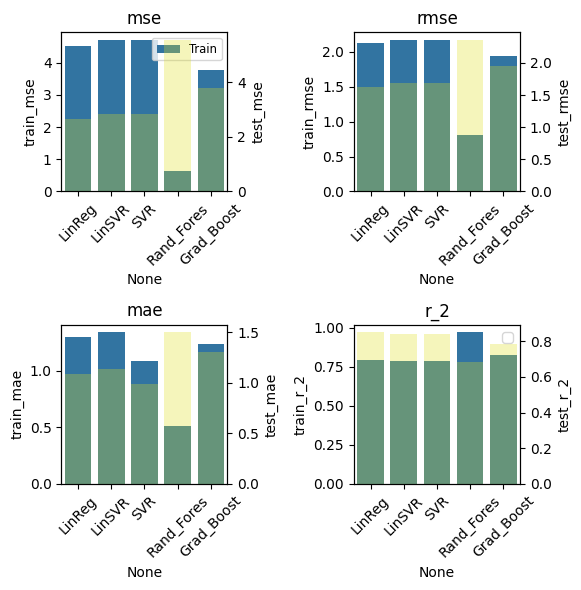

In [45]:
# Visually compare model scores for each of four metrics
# Create list of models
model_list = [best_linreg,best_linsvr,best_svr,best_rf,best_gb]
# Initalize list of models scores
scores = []
# Store model scores in list of lists
for i in model_list:
    trainpreds = i.predict(X_train)
    testpreds = i.predict(X_test)
    train_mse = mean_squared_error(y_train, trainpreds)
    test_mse = mean_squared_error(y_test, testpreds)
    train_rmse = (train_mse**0.5)
    test_rmse = (test_mse**0.5)
    train_mae = mean_absolute_error(y_train, trainpreds)
    test_mae = mean_absolute_error(y_test, testpreds)
    train_r_2 = r2_score(y_train,trainpreds)
    test_r_2 = r2_score(y_test,testpreds)
    scores.append([train_mse,test_mse,train_rmse,test_rmse,train_mae,test_mae,train_r_2,test_r_2])
# Make dataframe of scores by model
df_scores_processed = pd.DataFrame(scores, index=["LinReg","LinSVR","SVR","Rand_Fores","Grad_Boost"], 
                         columns=["train_mse","test_mse","train_rmse","test_rmse",
                                  "train_mae","test_mae","train_r_2","test_r_2"])

# View
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
# plt.title("Train/Test Fit Check")

# Set titles for each subplot
axs[0, 0].set_title("mse")
axs[0, 1].set_title("rmse")
axs[1, 0].set_title("mae")
axs[1, 1].set_title("r_2")
# Plot barplots on each subplot
sns.barplot(data=df_scores_processed, x=df_scores_processed.index, y="train_mse", ax=axs[0, 0],label="Train")
sns.barplot(data=df_scores_processed, x=df_scores_processed.index, y="train_rmse", ax=axs[0, 1])
sns.barplot(data=df_scores_processed, x=df_scores_processed.index, y="train_mae", ax=axs[1, 0])
sns.barplot(data=df_scores_processed, x=df_scores_processed.index, y="train_r_2", ax=axs[1, 1])
# Share axis for test scores
axs2 = [ax.twinx() for ax in axs.flat]
# Plot second set of bars on each subplot
sns.barplot(data=df_scores_processed, x=df_scores_processed.index, y="test_mse", ax=axs2[0], color='yellow', alpha=0.3)
sns.barplot(data=df_scores_processed, x=df_scores_processed.index, y="test_rmse", ax=axs2[1], color='yellow', alpha=0.3)
sns.barplot(data=df_scores_processed, x=df_scores_processed.index, y="test_mae", ax=axs2[2], color='yellow', alpha=0.3)
sns.barplot(data=df_scores_processed, x=df_scores_processed.index, y="test_r_2", ax=axs2[3], color='yellow', alpha=0.3)
# Rotate x-axis labels
axs.flat[0].tick_params(axis='x', labelrotation=45)
axs.flat[1].tick_params(axis='x', labelrotation=45)
axs.flat[2].tick_params(axis='x', labelrotation=45)
axs.flat[3].tick_params(axis='x', labelrotation=45)

fig.tight_layout()
axs[0, 0].legend(loc='upper right', fontsize='small')
# Show the plot
plt.legend()
plt.show()

# Based on these results, I am choosing th GB model as it performs sell across all metrics but is also robust to overfitting

In [51]:
random_state=42
finalgbr=GradientBoostingRegressor()
scorer = {'mse':'neg_mean_squared_error','mae':'neg_mean_absolute_error'}
finalparamgrid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['auto', 'sqrt', 'log2']
}

finalgbrCV = GridSearchCV(finalgbr,cv=5,param_grid=finalparamgrid, refit = 'mse', scoring = scorer, verbose=1)

# Fit the grid search
finalgbrCV.fit(X_train, y_train)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 0.9, 1.0]},
             refit='mse',
             scoring={'mae': 'neg_mean_absolute_error',
                      'mse': 'neg_mean_squared_error'},
             verbose=1)

In [52]:
BESTMODEL = finalgbrCV.best_estimator_
# print(BESTMODEL)
print(finalgbrCV.best_params_)
BESTTRAINPREDS = BESTMODEL.predict(X_train)
BESTTESTPREDS = BESTMODEL.predict(X_test)
print("train mse: ",mean_squared_error(y_train,BESTTRAINPREDS))
print("test mse: ",mean_squared_error(y_test,BESTTESTPREDS))
print("train mae: ",mean_absolute_error(y_train,BESTTRAINPREDS))
print("test mae: ",mean_absolute_error(y_test,BESTTESTPREDS))
print("train R2: ",r2_score(y_train,BESTTRAINPREDS))
print("test R2: ",r2_score(y_test,BESTTESTPREDS))

{'learning_rate': 0.1, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 1.0}
train mse:  0.03419135840631963
test mse:  3.9985041803048165
train mae:  0.11387925870663394
test mae:  1.4884854075566203
train R2:  0.9984461214736648
test R2:  0.7733454624043383


In [81]:
newdf = pd.read_csv('df_mi_10.csv')
subset = list(newdf.columns)
add = 'G3'
subset.append(add)
newdf = df[subset]

<class 'list'>


,G2,G1,absences,failures,famsup,schoolsup,Mjob,sex,age,Medu,G3
0,15,16,2,0,yes,no,teacher,F,16,4,15
1,5,6,0,3,no,no,other,M,18,1,0
2,11,10,2,0,yes,no,teacher,M,17,4,12
3,6,7,10,0,yes,no,services,F,15,3,6
4,14,13,0,0,no,no,other,M,16,2,14
...,...,...,...,...,...,...,...,...,...,...,...
311,9,8,0,3,no,no,services,M,15,2,10
312,5,6,6,0,yes,yes,other,F,17,4,6
313,16,16,0,0,no,no,teacher,F,15,4,15
314,5,7,0,1,no,no,services,F,19,2,0


In [93]:
# Process new data frame based on top10 MI Scores
X_train, X_test, y_train, y_test = data_prep(newdf, OHE, standard)

In [94]:
# Train on new data
random_state=42
gbr_mi10=GradientBoostingRegressor()
scorer = {'mse':'neg_mean_squared_error','mae':'neg_mean_absolute_error'}
gbr_mi10CV_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['auto', 'sqrt', 'log2']
}

gbr_mi10CV = GridSearchCV(gbr_mi10,cv=5,param_grid=gbr_mi10CV_param_grid, refit = 'mse', scoring = scorer, verbose=1)

# Fit the grid search
gbr_mi10CV.fit(X_train, y_train)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 0.9, 1.0]},
             refit='mse',
             scoring={'mae': 'neg_mean_absolute_error',
                      'mse': 'neg_mean_squared_error'},
             verbose=1)

In [95]:
GBR_mi10 = gbr_mi10CV.best_estimator_
# print(GBR_mi10)
print(gbr_mi10CV.best_params_)
BESTTRAINPREDS = GBR_mi10.predict(X_train)
BESTTESTPREDS = GBR_mi10.predict(X_test)
print("train mse: ",mean_squared_error(y_train,BESTTRAINPREDS))
print("test mse: ",mean_squared_error(y_test,BESTTESTPREDS))
print("train mae: ",mean_absolute_error(y_train,BESTTRAINPREDS))
print("test mae: ",mean_absolute_error(y_test,BESTTESTPREDS))
print("train R2: ",r2_score(y_train,BESTTRAINPREDS))
print("test R2: ",r2_score(y_test,BESTTESTPREDS))

{'learning_rate': 0.2, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 1.0}
train mse:  0.9525378039288016
test mse:  2.9231370208472742
train mae:  0.6606316477757245
test mae:  1.2587546856838931
train R2:  0.9567104640459726
test R2:  0.8343024691452513


In [96]:
df_combined = pd.read_csv('df_combined.csv')

In [97]:
# Process new data frame based on top10 MI Scores
X_train, X_test, y_train, y_test = data_prep(df_combined, OHE, standard)

In [98]:
# Train on new data
random_state=42
gbr_mi10=GradientBoostingRegressor()
scorer = {'mse':'neg_mean_squared_error','mae':'neg_mean_absolute_error'}
gbr_mi10CV_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['auto', 'sqrt', 'log2']
}

gbr_mi10CV = GridSearchCV(gbr_mi10,cv=5,param_grid=gbr_mi10CV_param_grid, refit = 'mse', scoring = scorer, verbose=1)

# Fit the grid search
gbr_mi10CV.fit(X_train, y_train)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 0.9, 1.0]},
             refit='mse',
             scoring={'mae': 'neg_mean_absolute_error',
                      'mse': 'neg_mean_squared_error'},
             verbose=1)

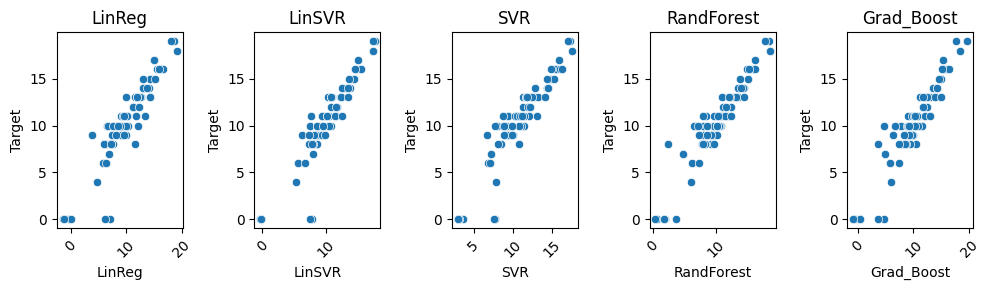

In [122]:
# USE THIS TO VISUALIZE FINAL PREDICTIONS VS. YTEST
# Visualize scatter of each model's target vs. predictions
# create dataframe with all model predictions and target
new_dict = {'LinReg': lrtestpreds, 'LinSVR': lsvrtestpreds, 'SVR': svrtestpreds,'RandForest':rfrtestpreds,"Grad_Boost":gbrtestpreds, "Target":y_test}
df_pred_true = pd.DataFrame(new_dict, columns=new_dict.keys())
df_pred_true
# Build Scatterplots
fig, axs = plt.subplots(1, 5, figsize=(10,3))

# Set titles for each subplot
axs[0].set_title("LinReg")
axs[1].set_title("LinSVR")
axs[2].set_title("SVR")
axs[3].set_title("RandForest")
axs[4].set_title("Grad_Boost")

# Plot scatterplots on each subplot
sns.scatterplot(data=df_pred_true, x="LinReg", y="Target", ax=axs[0])
sns.scatterplot(data=df_pred_true, x="LinSVR", y="Target", ax=axs[1])
sns.scatterplot(data=df_pred_true, x="SVR", y="Target", ax=axs[2])
sns.scatterplot(data=df_pred_true, x="RandForest", y="Target", ax=axs[3])
sns.scatterplot(data=df_pred_true, x="Grad_Boost", y="Target", ax=axs[4])


# Rotate x-axis labels
axs.flat[0].tick_params(axis='x', labelrotation=45)
axs.flat[1].tick_params(axis='x', labelrotation=45)
axs.flat[2].tick_params(axis='x', labelrotation=45)
axs.flat[3].tick_params(axis='x', labelrotation=45)
axs.flat[4].tick_params(axis='x', labelrotation=45)


fig.tight_layout()

# Show the plot
plt.show()

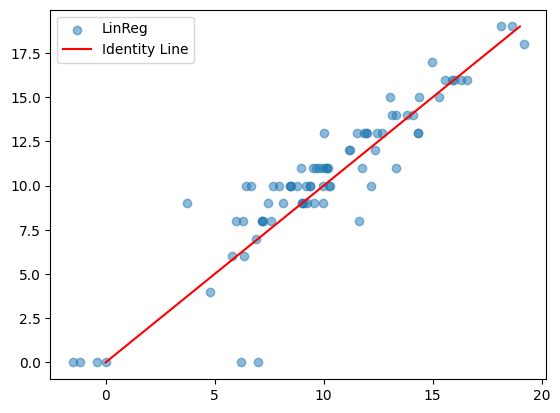

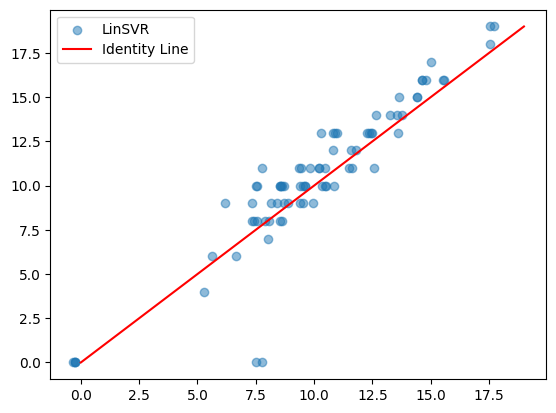

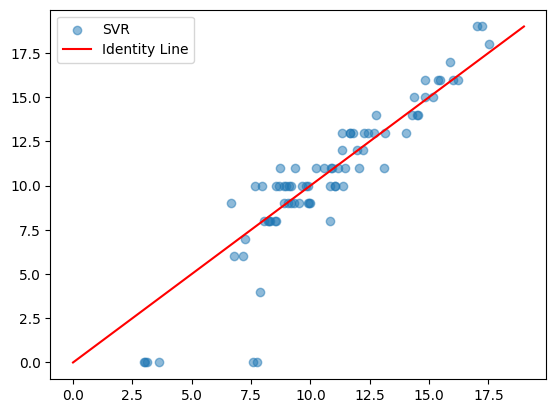

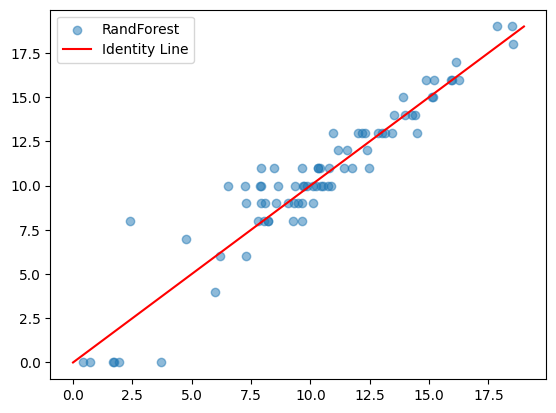

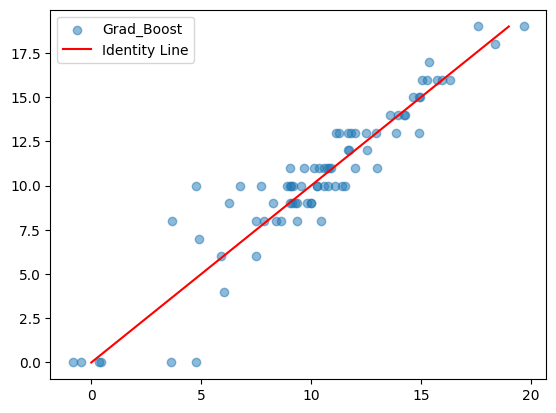

In [123]:
# Now again in more detail
for i in df_pred_true.columns[:-1]:
    plt.scatter(df_pred_true[i],y_test, alpha=0.5, label=f'{i}')
    # plt.scatter(y_test, gbrpreds, alpha=0.5, label='Gradient Boosting Regression')
    plt.plot(np.arange(20), np.arange(20), c='r', label='Identity Line')
    # Show legend
    plt.legend()
    plt.show()